In [1]:
# Load in packages for pandas, astropy, etc. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii
from astropy.table import Column, MaskedColumn
from astropy.io.ascii import masked
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import LambdaCDM 
from astroquery.simbad import Simbad
from astroquery.sdss import SDSS
from astropy.coordinates import match_coordinates_sky
import os 
import json 

cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7) #Creating our choice of cosmology here...

pd.set_option('display.max_columns', 300) # Setting max number of rows per df to be the size of the df
pd.set_option('display.max_rows', None)




In [2]:
# fixed stockton+91; double peaked --> doublepeak broad emission lines
# also did this for Puchnarewicz+1996 (but there are also double narrow peaks?)... prob should check with barry

In [3]:
# reading in the formatted version DR0p8
MAC = pd.read_csv('MAC_DR0p9.csv', sep=',')


In [4]:
import ast

def get_selection_method(waveband, technique):
    def filter_function(row):
        # Access the value in the 'Parsed Selection Method' column
        selection_method = row['Parsed Selection Method']
        
        # If the value is a string, convert it back to a dictionary
        if isinstance(selection_method, str):
            try:
                selection_dict = ast.literal_eval(selection_method)
            except ValueError:
                return False
        else:
            selection_dict = selection_method

        # Check if the waveband is a key and the technique is one of its values
        return str(waveband) in selection_dict and str(technique) in selection_dict[str(waveband)]

    return filter_function

def get_analysis_method(waveband, technique):
    def filter_function(row):
        # Access the value in the 'Parsed Selection Method' column
        analysis_method = row['Parsed Analysis Method']
        
        # If the value is a string, convert it back to a dictionary
        if isinstance(analysis_method, str):
            try:
                analysis_dict = ast.literal_eval(analysis_method)
            except ValueError:
                return False
        else:
            analysis_dict = analysis_method

        # Check if the waveband is a key and the technique is one of its values
        return str(waveband) in analysis_dict and str(technique) in analysis_dict[str(waveband)]

    return filter_function

## Apply the filter function with specific waveband and technique
#filter_selection = get_selection_method('Optical', 'Spectroscopy')
#df_selection = MAC[MAC.apply(filter_selection, axis=1)]
#
#filter_analysis = get_analysis_method('X-ray', 'Imaging')
#df_analysis = MAC[MAC.apply(filter_analysis, axis=1)]



In [4]:
filter_selection = get_selection_method('Radio', 'Imaging')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
len(df_selection)


df_selection = df_selection[(df_selection['Paper(s)']!='Yang+2019') & \
                           (df_selection['Paper(s)']!='Yang+2019 ; Joshi+2019') & \
                           (df_selection['Paper(s)']!='Proctor+2011') & \
                           (df_selection['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Lal+2019') & \
                           (df_selection['Paper(s)']!='Orosz+2013') & \
                           (df_selection['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                           (df_selection['Paper(s)']!='Cheung+2007 ; Proctor+2011 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018 ; Lal+2019') & \
                           (df_selection['Paper(s)']!='Proctor+2011 ; Yang+2019 ; Joshi+2019') & \
                           (df_selection['Paper(s)']!='Yuan+2016 ; Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                           (df_selection['Paper(s)']!='Yuan+2016 ; Yang+2019 ; Joshi+2019') & \
                           (df_selection['Paper(s)']!='Proctor+2011 ; Yang+2019') & \
                           (df_selection['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018 ; Lal+2019') & \
                           (df_selection['Paper(s)']!='Cheung+2007 ; Roberts+2018') & \
                           (df_selection['Paper(s)']!='Cheung+2007 ; Proctor+2011 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                           (df_selection['Paper(s)']!='Proctor+2011 ; Yang+2019') & \
                           (df_selection['Paper(s)']!='Proctor+2011 ; Yang+2019') ]

df_selection[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]




NameError: name 'MAC2' is not defined

In [ ]:
band = ['Optical']
tech = ['Double-Peaked Spectroscopic Emission Lines', 'Fiber Spectroscopy', 'Spectroscopic Emission Line Ratios',\
        'Spectroscopy','IFU Spectroscopy', 'Long-Slit Spectroscopy']

for i in band:
    for j in tech:
        filter_selection = get_selection_method(str(i), str(j))
        df_selection = MAC[MAC.apply(filter_selection, axis=1)]
        print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))

In [ ]:
band = ['Optical']
tech = ['Double-Peaked Spectroscopic Emission Lines', 'Fiber Spectroscopy', 'Spectroscopic Emission Line Ratios',\
        'Spectroscopy','IFU Spectroscopy', 'Long-Slit Spectroscopy']
band2 = ['X-ray']
tech2 = ['Imaging']

for i in band:
    for j in tech:
        filter_selection = get_selection_method(str(i), str(j))
        df_selection = MAC[MAC.apply(filter_selection, axis=1)]
        print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        #for k in band2:
        #    for m in tech2:
        #        filter_selection = get_selection_method(str(k), str(m))
        #        df_selection = df_selection[df_selection.apply(filter_selection, axis=1)] 
        #        print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
            

In [5]:
# here we're testing out the plotting for objects that have optical spectroscopy as a selection technique

MAC1 = MAC[(MAC['Primary System Type']=='Dual AGN') | (MAC['Primary System Type']=='Dual AGN Candidate') | \
           (MAC['Primary System Type']=='Dual SMBH Candidate') | \
           (MAC['Primary System Type']=='Dual AGN Candidate ; Dual SMBH Candidate')]

MAC2 = MAC[(MAC['Primary System Type']=='Binary AGN') | (MAC['Secondary System Type']=='Binary AGN Candidate') | \
           (MAC['Secondary System Type']=='Binary SMBH Candidate') | (MAC['Primary System Type']=='Binary AGN Candidate') |\
           (MAC['Primary System Type']=='Binary AGN Candidate ; Binary SMBH Candidate') | \
           (MAC['Secondary System Type']=='Binary AGN Candidate ; Binary SMBH Candidate') | \
          (MAC['Primary System Type']=='Binary SMBH Candidate')]

MAC3 = MAC[(MAC['Primary System Type']=='Recoil Candidate') | (MAC['Secondary System Type']=='Recoil Candidate') | \
           (MAC['Tertiary System Type']=='Recoil Candidate')]


print(len(MAC1),len(MAC2),len(MAC3))

4336 1369 581


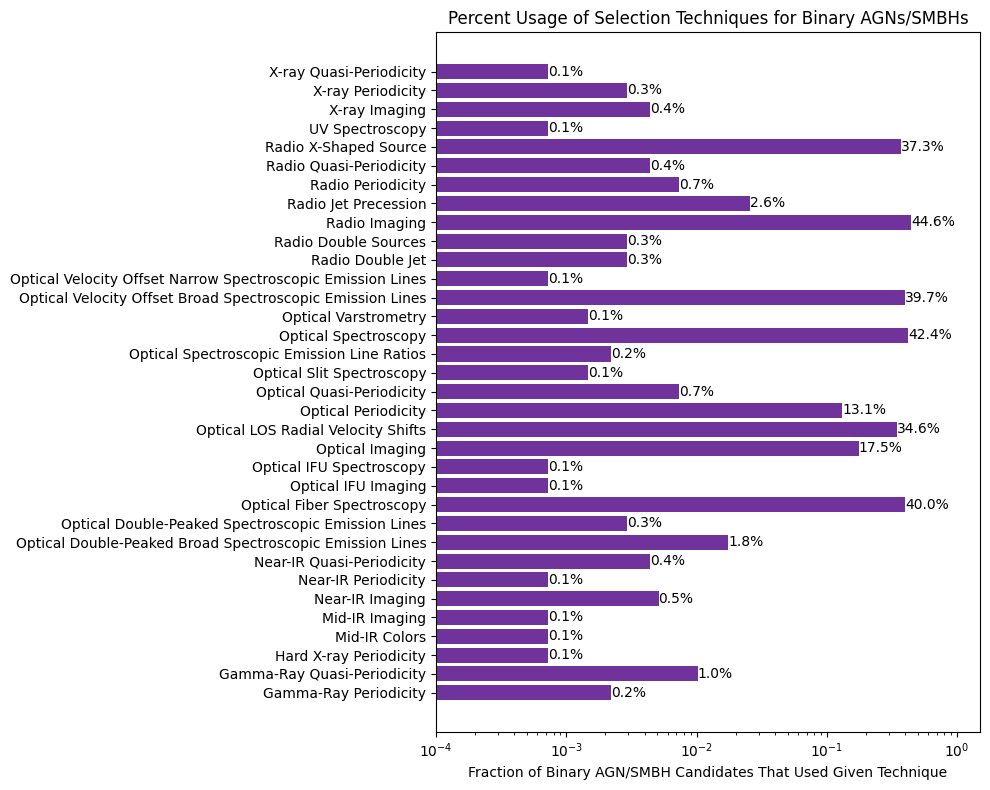

In [53]:
wavebands = ['Gamma-Ray',
 'Gamma-Ray',
 'Hard X-ray',
 'Hard X-ray',
 'Infrared',
 'Mid-IR',
 'Mid-IR',
 'Mid-IR',
 'Near-IR',
 'Near-IR',
 'Near-IR',
 'Near-IR',
 'Near-IR',
 'Near-IR',
 'Near-IR',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',
 'Optical',    
 'Optical',
 'Mid-IR',
 'Radio',
 'Radio',
 'Radio',
 'Radio',
 'Radio',
 'Radio',
 'Radio',
 'Radio',
 'Infrared',
 'Radio',
 'Optical',
 'Submillimeter',
 'UV',
 'UV',
 'X-ray',
 'X-ray',
 'X-ray',
 'X-ray',
 'X-ray']

techniques = ['Periodicity',
 'Quasi-Periodicity',
 'BAT Selection',
 'Periodicity',
 'Luminosity',
 'Colors',
 'Imaging',
 'Spectroscopy',
 'Colors',
 'Imaging',
 'Periodicity',
 'Positional Offset',
 'Quasi-Periodicity',
 'Slit Spectroscopy',
 'Spectroscopy',
 'Astrometry',
 'Double-Peaked Broad Spectroscopic Emission Lines',
 'Double-Peaked Spectroscopic Emission Lines',
 'Fiber Spectroscopy',
 'IFU Imaging',
 'IFU Spectroscopy',
 'Imaging',
 'LOS Radial Velocity Shifts',
 'Long-Slit Spectroscopy',
 'Narrow-Band Imaging',
 'Optical LOS Radial Velocity Shifts',
 'Periodicity',
 'Photometry',
 'Quasi-Periodicity',
 'Slit Spectroscopy',
 'Slitless Spectroscopy',
 'Spectroscopic Emission Line Ratios',
 'Spectroscopy',
 'Varstrometry',
 'Velocity Offset Broad Spectroscopic Emission Lines',
 'Velocity Offset Narrow Spectroscopic Emission Lines',
 'Optical-Mid-IR Colors',
 'Optical-Mid-IR Colors',
 'Double Jet',
 'Double Sources',
 'Imaging',
 'Jet Precession',
 'Periodicity',
 'Quasi-Periodicity',
 'X-Shaped Source',
 'Radio-Infrared Colors',
 'Radio-Infrared Colors',
 'Radio-Optical Offsets',
 'Radio-Optical Offsets',
 'Imaging',
 'Imaging',
 'Spectroscopy',
 'Imaging',
 'Periodicity',
 'Positional Offset',
 'Quasi-Periodicity',
 'Spectroscopy']

# Optical Imaging --> subtract 2
#
# Optical Offset Narrow Emission Lines --> subtract 1
# Optical double-peaked spec lines --> subtract 19
#
# Optical fiber spec --> subtract 17
# optical spec -->  subtract 15
# optical spec line ratios --> subtract 19

norm = len(MAC2)
labels = []
counts = []
for i, j in zip(wavebands,techniques):
    filter_selection = get_selection_method(str(i), str(j))
    df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
    if str(i)+' '+str(j) == 'Optical Imaging':
        count = len(df_selection)-2
        counts.append(count/norm)
        labels.append(str(i)+' '+str(j))
    elif str(i)+' '+str(j) == 'Optical Velocity Offset Narrow Spectroscopic Emission Lines':
        count = len(df_selection)-1
        counts.append(count/norm)
        labels.append(str(i)+' '+str(j))
    elif str(i)+' '+str(j) == 'Optical Double-Peaked Spectroscopic Emission Lines':
        count = len(df_selection)-19
        counts.append(count/norm)
        labels.append(str(i)+' '+str(j))
    elif str(i)+' '+str(j) == 'Optical Fiber Spectroscopy':
        count = len(df_selection)-17
        counts.append(count/norm)
        labels.append(str(i)+' '+str(j))
    elif str(i)+' '+str(j) == 'Optical Spectroscopy':
        count = len(df_selection)-15
        counts.append(count/norm)
        labels.append(str(i)+' '+str(j))
    elif str(i)+' '+str(j) == 'Optical Spectroscopic Emission Line Ratios':
        count = len(df_selection)-19
        counts.append(count/norm)
        labels.append(str(i)+' '+str(j))        
    else:
        count = len(df_selection)
        counts.append(count/norm)
        labels.append(str(i)+' '+str(j))

order = range(len(wavebands))
for i in reversed(order): # reversing our iteration order so we don't screw up our indexes
    if float((counts[i]*norm))<1.0:
        wavebands.pop(i)
        techniques.pop(i)
        counts.pop(i)
        labels.pop(i)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(labels, counts, color='indigo', alpha = 0.8, log=True)

for bar in bars:
    width = bar.get_width()  # Use get_width for horizontal bars
    if width > 0.0001:  # Adjust this threshold if necessary
        percentage = f'{100 * width:.1f}%'  # Calculate the percentage based on the bar's width
        ax.text(width, bar.get_y() + bar.get_height() / 2, percentage,  # Position the text at the end of the bar
                ha='left', va='center', fontsize=10)  # Adjust text alignment

ax.set_xlim([0.0001, 1.5]) 

plt.xlabel('Fraction of Binary AGN/SMBH Candidates That Used Given Technique')
plt.title('Percent Usage of Selection Techniques for Binary AGNs/SMBHs')
plt.tight_layout()
plt.savefig('BinaryAGN_selectmethods_aggregate.pdf', dpi=150)
plt.show()

#bars = ax2.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.2, hatch='x', label='Selection Methods Independent of Optical\nSpectroscopy that Recover the Same Objects')
#xlabels = ax2.get_xticklabels()
#ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
#ax2.legend()

#for bar in bars:
#    height = bar.get_height()
#    if height>0.0001:
#        percentage = f'{100*height:.1f}%'
#        ax2.text(bar.get_x() + bar.get_width() / 2, height, percentage,
#                ha='center', va='bottom', fontsize=12)



In [40]:
# we'll need to clean this up...
filter_selection = get_selection_method('Optical', 'Imaging') 
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
len(df_selection)
 
# Optical Colors --> get rid of
# Optical Imaging --> subtract 2
# Optical Positional Offset --> get rid of
#
# Optical IFU Imaging --> this is fine
# Optical IFU Spectroscopy --> this is fine
#
# Optical Offset Narrow Emission Lines --> subtract 1
# optical offset broad lines --> fine i think
# Optical double-peaked spec lines --> subtract 19
#
# Optical fiber spec --> subtract 17
# optical spec -->  subtract 15
# optical spec line ratios --> subtract 19
# optical slit spec --> this is fine
#
# Mid-IR Colors --> this is fine
# Mid-IR Imaging --> this is fine
#
# Near-IR Imaging --> this is fine
#
# UV spectroscopy --> this is fine (but we're missing 1 for borrows... which will be turned back to optical spec)
# UV double-peaked .... --> remove completely
#
# X-ray imaging --> this is fine 
#

df_selection

Unnamed: 0.1  Unnamed: 0  \
1374          1374        1711   
1494          1494        1877   
1495          1495        1878   
1496          1496        1879   
1497          1497        1880   
1498          1498        1881   
1499          1499        1882   
1500          1500        1883   
1501          1501        1884   
1502          1502        1885   
1503          1503        1886   
1504          1504        1887   
1505          1505        1888   
1506          1506        1889   
1507          1507        1890   
1508          1508        1891   
1509          1509        1892   
1510          1510        1893   
1511          1511        1894   
1512          1512        1895   
1513          1513        1896   
1514          1514        1897   
1515          1515        1898   
1516          1516        1899   
1517          1517        1900   
1518          1518        1901   
1519          1519        1902   
1520          1520        1903   
1521          1521        1904   
1522          1522        1905   
1523          1523        1906   
1524          1524        1907   
1525          1525        1908   
1526          1526        1909   
1527          1527        1910   
1528          1528        1911   
1529          1529        1912   
1530          1530        1913   
1531          1531        1914   
1532          1532        1915   
1533          1533        1916   
1534          1534        1917   
1535          1535        1918   
1536          1536        1919   
1537          1537        1920   
1538          1538        1921   
1539          1539        1922   
1540          1540        1923   
1541          1541        1924   
1542          1542        1925   
1543          1543        1926   
1544          1544        1927   
1545          1545        1928   
1546          1546        1929   
1547          1547        1930   
1548          1548        1931   
1549          1549        1932   
1550          1550        1933   
1551          1551        1934   
1552          1552        1935   
1553          1553        1936   
1554          1554        1937   
1555          1555        1938   
1556          1556        1939   
1557          1557        1940   
1558          1558        1941   
1559          1559        1942   
1560          1560        1943   
1561          1561        1944   
1562          1562        1945   
1563          1563        1946   
1564          1564        1947   
1565          1565        1948   
1566          1566        1949   
1567          1567        1950   
1568          1568        1951   
1569          1569        1952   
1570          1570        1953   
1571          1571        1954   
1572          1572        1955   
1573          1573        1956   
1574          1574        1957   
1575          1575        1958   
1576          1576        1959   
1577          1577        1960   
1578          1578        1961   
1579          1579        1962   
1580          1580        1963   
1581          1581        1964   
1582          1582        1965   
1583          1583        1966   
1584          1584        1967   
1585          1585        1968   
1586          1586        1969   
1587          1587        1970   
1588          1588        1971   
1589          1589        1972   
1590          1590        1973   
1591          1591        1974   
1592          1592        1975   
1593          1593        1976   
1594          1594        1977   
1595          1595        1978   
1596          1596        1979   
1597          1597        1980   
1598          1598        1981   
1599          1599        1982   
1600          1600        1983   
1601          1601        1984   
1602          1602        1985   
1603          1603        1986   
1604          1604        1987   
1605          1605        1988   
1606          1606        1989   
1607          1607        1990   
1608          1608        1991   
1609          1609        19

In [42]:
for index, row in df_selection.iterrows():
    if 'Orosz+2013' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)


for index, row in df_selection.iterrows():
    if 'Charisi+2016' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)
for index, row in df_selection.iterrows():
    if 'Graham+2015' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)
        

df_selection

/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_16892/642518897.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection.drop(index, inplace=True)
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_16892/642518897.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection.drop(index, inplace=True)
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_16892/642518897.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

Unnamed: 0.1  Unnamed: 0  \
2529          2529        2912   
2948          2948        3412   
2951          2951        3415   
2953          2953        3417   
2963          2963        3427   
2965          2965        3429   
2969          2969        3433   
2970          2970        3434   
2975          2975        3439   
2976          2976        3440   
2977          2977        3441   
2980          2980        3444   
2982          2982        3446   
2984          2984        3448   
2989          2989        3453   
2990          2990        3454   
3018          3018        3482   
3019          3019        3483   
3020          3020        3484   
3021          3021        3485   
3040          3040        3504   
3041          3041        3505   
3042          3042        3506   
3064          3064        3528   
3065          3065        3529   
3080          3080        3544   
3083          3083        3547   
3084          3084        3548   
3090          3090        3554   
3092          3092        3556   
3100          3100        3564   
3101          3101        3565   
5564          5564        6036   

                                            System Type  \
2529  Dual AGN Candidate / Binary AGN Candidate / Re...   
2948                               Binary AGN Candidate   
2951                               Binary AGN Candidate   
2953                              Binary SMBH Candidate   
2963    Binary Quasar Candidate / Binary SMBH Candidate   
2965                              Binary SMBH Candidate   
2969            Binary AGN Candidate / Recoil Candidate   
2970                               Binary AGN Candidate   
2975                               Binary AGN Candidate   
2976                               Binary AGN Candidate   
2977                               Binary AGN Candidate   
2980                               Binary AGN Candidate   
2982                               Binary AGN Candidate   
2984                               Binary AGN Candidate   
2989                               Binary AGN Candidate   
2990                               Binary AGN Candidate   
3018                               Binary AGN Candidate   
3019                               Binary AGN Candidate   
3020                               Binary AGN Candidate   
3021                               Binary AGN Candidate   
3040                               Binary AGN Candidate   
3041                               Binary AGN Candidate   
3042                               Binary AGN Candidate   
3064          Dual AGN Candidate / Binary AGN Candidate   
3065          Dual AGN Candidate / Binary AGN Candidate   
3080  Dual SMBH Candidate / Binary SMBH Candidate / ...   
3083                               Binary AGN Candidate   
3084                               Binary AGN Candidate   
3090                               Binary AGN Candidate   
3092                               Binary AGN Candidate   
3100                               Binary AGN Candidate   
3101                               Binary AGN Candidate   
5564  Binary SMBH Candidate / Recoil Candidate / Dua...   

                                    Literature Name  \
2529                                            -99   
2948                                       NGC 5548   
2951                                         OJ 287   
2953                                         3C 120   
2963                                   PKS 0537-441   
2965                                         3C 345   
2969                                      E1821+643   
2970                                         3C 279   
2975                                       3C 454.3   
2976                                    S4 0954+658   
2977                                    AO 0235+164   
2980                                         BL LAC   
2982                                   PKS 2155-304   
2984                                       NGC 4151   
2989             

In [38]:
for index, row in df_selection.iterrows():
    if 'Liu+2014' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)


for index, row in df_selection.iterrows():
    if 'Ju+2013' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)
for index, row in df_selection.iterrows():
    if 'Shen+2013' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)
        
for index, row in df_selection.iterrows():
    if 'Eracleous+2012' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)

for index, row in df_selection.iterrows():
    if 'Eracleous+1994' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)
for index, row in df_selection.iterrows():
    if 'Tsalmantza+2011' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)
for index, row in df_selection.iterrows():
    if 'Lewis+2010' in row['Paper(s)']:
        df_selection.drop(index, inplace=True)
         

/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_16892/1468883837.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection.drop(index, inplace=True)
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_16892/1468883837.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selection.drop(index, inplace=True)
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_16892/1468883837.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [39]:
df_selection

Unnamed: 0.1  Unnamed: 0  \
827            827         827   
1374          1374        1711   
1808          1808        2191   
1839          1839        2222   
2081          2081        2464   
2529          2529        2912   
2945          2945        3409   
2948          2948        3412   
2949          2949        3413   
2950          2950        3414   
2953          2953        3417   
2954          2954        3418   
2955          2955        3419   
2956          2956        3420   
2969          2969        3433   
2984          2984        3448   
2990          2990        3454   
3036          3036        3500   
3037          3037        3501   
3038          3038        3502   
3080          3080        3544   
3083          3083        3547   
3088          3088        3552   
3092          3092        3556   
3093          3093        3557   
3247          3247        3711   
3290          3290        3754   
3428          3428        3892   
3489          3489        3953   
3600          3600        4064   
3994          3994        4458   
4375          4375        4839   
4540          4540        5004   
4634          4634        5098   
4641          4641        5105   
4707          4707        5171   
4869          4869        5333   
4927          4927        5391   

                                            System Type      Literature Name  \
827           Dual AGN Candidate / Binary AGN Candidate                  -99   
1374  Dual AGN Candidate / Binary AGN Candidate / Bi...                  -99   
1808  Dual SMBH Candidate / Binary AGN Candidate / R...                  -99   
1839         Dual SMBH Candidate / Binary AGN Candidate                  -99   
2081       Binary AGN Candidate / Binary SMBH Candidate                  -99   
2529  Dual AGN Candidate / Binary AGN Candidate / Re...                  -99   
2945  Binary AGN Candidate / Binary AGN Candidate / ...               3C 227   
2948                               Binary AGN Candidate             NGC 5548   
2949                              Binary SMBH Candidate             Arp 102B   
2950                              Binary SMBH Candidate               3C 332   
2953                              Binary SMBH Candidate               3C 120   
2954                               Binary AGN Candidate        RX J1042+1212   
2955                               Binary AGN Candidate               OX 169   
2956                              Binary SMBH Candidate             3C 390.3   
2969            Binary AGN Candidate / Recoil Candidate            E1821+643   
2984                               Binary AGN Candidate             NGC 4151   
2990                               Binary AGN Candidate              Mrk 231   
3036                               Binary AGN Candidate               3C 382   
3037                               Binary AGN Candidate             NGC 1097   
3038                               Binary AGN Candidate         SBS 1518+593   
3080  Dual SMBH Candidate / Binary SMBH Candidate / ...             NGC 3115   
3083                               Binary AGN Candidate              Ark 120   
3088                              Binary SMBH Candidate                Mrk 6   
3092                               Binary AGN Candidate      SDSS J0159+0105   
3093           Binary SMBH Candidate / Recoil Candidate           J0437+2456   
3247          Dual AGN Candidate / Binary AGN Candidate                  -99   
3290  Dual AGN Candidate / Recoil Candidate / Binary...                  -99   
3428  Dual AGN Candidate / Recoil Candidate / Binary...                  -99   
3489  Dual AGN Candidate / Dual AGN Candidate / Bina...                  -99   
3600          Dual AGN Candidate / Binary AGN Candidate  J104807.74+005543.4   
3994          Dual AGN Candidate / Binary AGN Candidate                  -99   
4375  Dual AGN Candidate / Binary AGN Candidate / Re...                  -99   
4540  Dual AGN Candidate / Recoil Candi

In [ ]:
# now we're going to focus on the binaries 


In [44]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('Optical', 'Spectroscopy')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
#df_selection['Parsed Selection Method'].unique()


In [45]:
data = df_selection['Parsed Selection Method'].unique()
dicts = [ast.literal_eval(d) for d in data]

# Step 2: Aggregate all entries into a single list
all_entries = []
for d in dicts:
    for key, values in d.items():
        for value in values:
            all_entries.append((key, value))

# Step 3: Remove duplicates by converting list of tuples into a set
unique_entries = set(all_entries)

# Optionally, convert back to list of dictionaries or keep as list of tuples
#unique_dicts = [{k: v} for k, v in unique_entries]

#print(unique_dicts)
unique_entries_list = list(unique_entries)

# Sort the list by the first element of each tuple (the key) and then by the second element (the value)
sorted_unique_entries = sorted(unique_entries_list, key=lambda x: (x[0], x[1]))

for i in sorted_unique_entries:
    print(i)

('Optical', 'Colors')
('Optical', 'Double-Peaked Broad Spectroscopic Emission Lines')
('Optical', 'Double-Peaked Spectroscopic Emission Lines')
('Optical', 'Fiber Spectroscopy')
('Optical', 'IFU Imaging')
('Optical', 'IFU Spectroscopy')
('Optical', 'Imaging')
('Optical', 'LOS Radial Velocity Shifts')
('Optical', 'Periodicity')
('Optical', 'Positional Offset')
('Optical', 'Radio-Optical Positional Offsets')
('Optical', 'Slit Spectroscopy')
('Optical', 'Spectroscopic Emission Line Ratios')
('Optical', 'Spectroscopy')
('Optical', 'Velocity Offset Broad Spectroscopic Emission Lines')
('Optical', 'Velocity Offset Narrow Spectroscopic Emission Lines')
('Radio', 'Imaging')
('Radio', 'Jet Precession')
('Radio', 'Radio-Optical Positional Offsets')
('Radio', 'X-Shaped Source')
('UV', 'Spectroscopy')


/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/3512209118.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gandalf.drop(index, inplace=True)
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/3512209118.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gandalf.drop(index, inplace=True)
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/3512209118.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

582
24 Optical Double-Peaked Broad Spectroscopic Emission Lines
13 Optical Double-Peaked Spectroscopic Emission Lines
552 Optical Fiber Spectroscopy
1 Optical IFU Imaging
1 Optical IFU Spectroscopy
11 Optical Imaging
474 Optical LOS Radial Velocity Shifts
9 Optical Periodicity
2 Optical Slit Spectroscopy
12 Optical Spectroscopic Emission Line Ratios
582 Optical Spectroscopy
544 Optical Velocity Offset Broad Spectroscopic Emission Lines
1 Optical Velocity Offset Narrow Spectroscopic Emission Lines
1 UV Spectroscopy
10 Radio Imaging
6 Radio Jet Precession


/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/3512209118.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/3512209118.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(tech1+techadd, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/3512209118.py:166: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/3512209118.py:196: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')


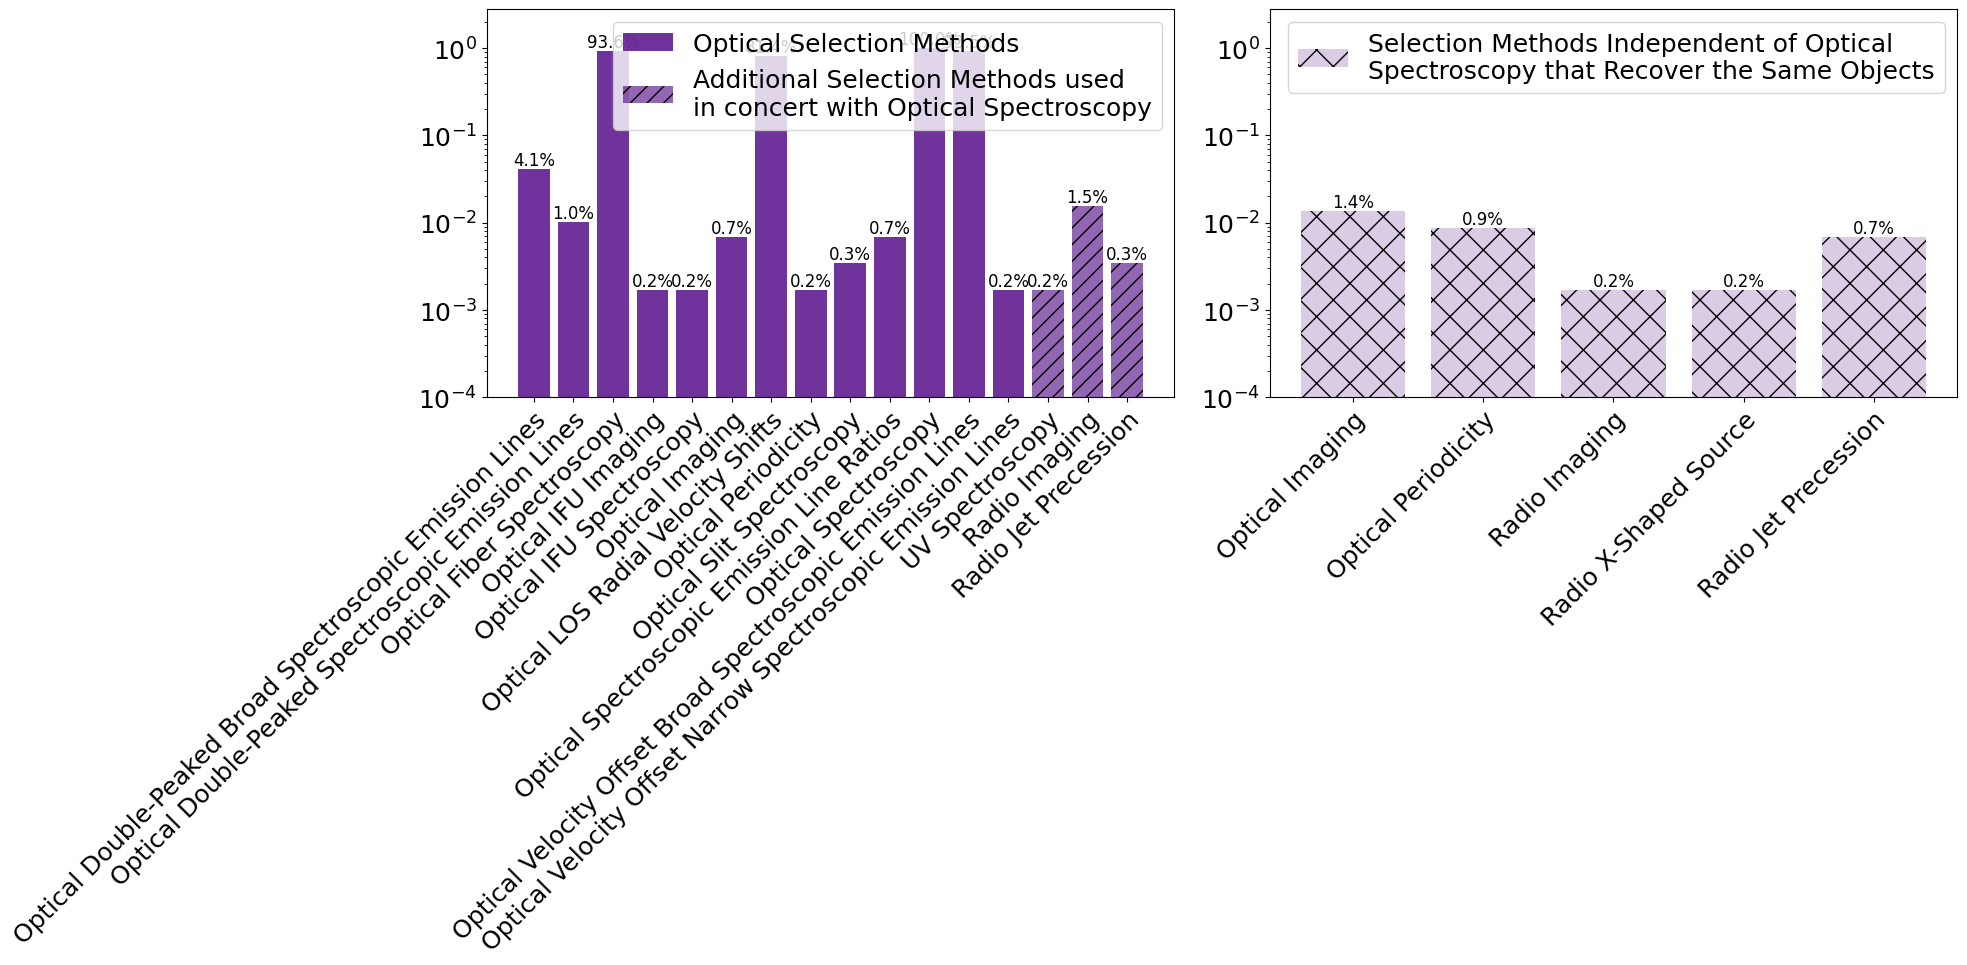

In [42]:
# here we're testing out the plotting for objects that have optical spectroscopy as a selection technique
#('Optical', 'Colors') *
#('Optical', 'Double-Peaked Broad Spectroscopic Emission Lines') *
#('Optical', 'Double-Peaked Spectroscopic Emission Lines') *
#('Optical', 'Fiber Spectroscopy') *
#('Optical', 'IFU Imaging') *
#('Optical', 'IFU Spectroscopy') *
#('Optical', 'Imaging') *
#('Optical', 'LOS Radial Velocity Shifts') *
#('Optical', 'Periodicity') *
#('Optical', 'Positional Offset') *
#('Optical', 'Radio-Optical Positional Offsets') *
#('Optical', 'Slit Spectroscopy') *
#('Optical', 'Spectroscopic Emission Line Ratios') *
#('Optical', 'Spectroscopy') *
#('Optical', 'Velocity Offset Broad Spectroscopic Emission Lines') *
#('Optical', 'Velocity Offset Narrow Spectroscopic Emission Lines') *
#('Radio', 'Imaging') *
#('Radio', 'Jet Precession') *
#('Radio', 'Radio-Optical Positional Offsets') *
#('Radio', 'X-Shaped Source') *
#('UV', 'Spectroscopy')

band = ['Optical']
tech = ['Double-Peaked Broad Spectroscopic Emission Lines','Double-Peaked Spectroscopic Emission Lines',\
        'Fiber Spectroscopy','IFU Imaging','IFU Spectroscopy','Imaging','LOS Radial Velocity Shifts',\
        'Periodicity','Slit Spectroscopy',\
        'Spectroscopic Emission Line Ratios','Spectroscopy','Velocity Offset Broad Spectroscopic Emission Lines',\
        'Velocity Offset Narrow Spectroscopic Emission Lines']  #'Positional Offset',
band2 = ['UV']
tech2 = ['Spectroscopy']
band6 = ['Radio']
tech6 = ['Imaging','Jet Precession'] #'Double Sources','Radio-Optical Positional Offsets','X-Shaped Source'


bars = tech
num = []

filter_selection = get_selection_method('Optical', 'Spectroscopy')
gandalf = MAC2[MAC2.apply(filter_selection, axis=1)]

# we have to drop the objects improperly selected via optical spectroscopy...
names=['J083127.50+321926.9 / B2 0828+32','J094124+394441 / 3C223.1','J100601.74+345410.5','J161847.93+215925.4',\
       'J003636.21+004853.45','J155416.08+381132.64','J091405.28+171554.36','J131638.16+242732.40',\
       'J014719.27-085119.58','J011341.11+010608.50','J114016.98+174340.4','SDSSJ081617.73+293639.6',\
       'SDSSJ152806.63+132345.8 / J1528+1323']
for i in names:
    for index, row in gandalf.iterrows():
        if row['Name1']==str(i):
            gandalf.drop(index, inplace=True)
    
print(len(gandalf))
norm = len(gandalf)

# tally to remove from main chart
# opt spec none
# fiber spec 2
# double peak  7
# spec ratios 8
# tally to remove
#8 optical imaging
# remove 8 pweriodicity
for i in band:
    for j in tech:
        filter_selection = get_selection_method(str(i), str(j))
        df_selection = gandalf[gandalf.apply(filter_selection, axis=1)]
        if j=='Imaging':
            num.append((len(df_selection)-7)/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='Periodicity':
            num.append((len(df_selection)-8)/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='LOS Radial Velocity Shifts':
            num.append((len(df_selection))/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='Spectroscopy':
            num.append((len(df_selection))/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='Fiber Spectroscopy':
            num.append((len(df_selection)-7)/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='Double-Peaked Spectroscopic Emission Lines':
            num.append((len(df_selection)-7)/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='Spectroscopic Emission Line Ratios':
            num.append((len(df_selection)-8)/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        else:
            num.append(len(df_selection)/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))

tech1 = []
for i in tech:
    tech1.append('Optical '+str(i))
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
plt.rcParams.update({'font.size': 18})

#ax1.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Radio Selection Methods')

bars = ax1.bar(tech1, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Optical Selection Methods')
for bar in bars:
    height = bar.get_height()
    if height>0.0001:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

   

techadd=[]
num=[]
for k in band2:
    for m in tech2:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        num.append(len(df_selection2)/norm)
        print(str(len(df_selection2)) + ' ' + str(k) + ' ' + str(m))

for i in tech2:
    techadd.append('UV '+str(i))

# radioimaging
#remove 1
#add 1 independent 

# x-shape radio source 
#remove from list
#add to second chart

# jet precession
# remove 4 
# add 4 to indpenddent chart  (we'll need to fiz this when we add back in radio imaging..)
for k in band6:
    for m in tech6:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        if m=='Imaging':
            num.append((len(df_selection2)-1)/norm)
            print(str(len(df_selection2)) + ' ' + str(k) + ' ' + str(m))
        elif m=='Jet Precession':
            num.append((len(df_selection2)-4)/norm)
            print(str(len(df_selection2)) + ' ' + str(k) + ' ' + str(m))
        else:
            num.append((len(df_selection2))/norm)
            print(str(len(df_selection2)) + ' ' + str(k) + ' ' + str(m))

for i in tech6:
    techadd.append('Radio '+str(i))
    

bars = ax1.bar(techadd, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.6, hatch='//', label='Additional Selection Methods used\nin concert with Optical Spectroscopy')
#xlabels =  ax1.get_xticklabels()
ax1.set_xticklabels(tech1+techadd, rotation=45, ha='right', rotation_mode='anchor')
#ax1.text(0.2, 0.9, 'Object Class: Dual AGN/SMBH Candidates\nSelection Breakdown: Radio Imaging', transform=ax1.transAxes, fontsize=18)

for bar in bars:
    height = bar.get_height()
    if height>0.0001:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

ax1.legend()


# the second bar chart will go below here...
# tally to add to second chart
#8 optical imaging
# add 5 periodicity

# radioimaging
#remove 1
#add 1 independent 

# x-shape radio source 
#remove from list
#add to second chart

# jet precession
# remove 4 
# add 4 to indpenddent chart  (we'll need to fiz this when we add back in radio imaging..)



tech = ['Optical Imaging','Optical Periodicity','Radio Imaging','Radio X-Shaped Source','Radio Jet Precession']
num = [8/norm,5/norm,1/norm,1/norm,4/norm]


bars = ax2.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.2, hatch='x', label='Selection Methods Independent of Optical\nSpectroscopy that Recover the Same Objects')
xlabels = ax2.get_xticklabels()
ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
ax2.legend()

for bar in bars:
    height = bar.get_height()
    if height>0.0001:
        percentage = f'{100*height:.1f}%'
        ax2.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)

ax1.set_ylim([0.0001, 2.8]) 
ax2.set_ylim([0.0001, 2.8]) 

plt.tight_layout()
plt.savefig('binaryagn_breakdown_optspec.pdf', dpi=150)
plt.show()



In [ ]:
gandalf = gandalf[(gandalf['Paper(s)']!='Liu+2014') & \
                  (gandalf['Paper(s)']!='Liu+2014 ; Guo+2019') & \
                  (gandalf['Paper(s)']!='Eracleous+1994') & \
                  (gandalf['Paper(s)']!='Ju+2013') & \
                  (gandalf['Paper(s)']!='Ju+2013 ; Wang+2017') & \
                  (gandalf['Paper(s)']!='Eracleous+2012 ; Runnoe+2015 ; Runnoe+2017 ; Nguyen+2020') & \
                  (gandalf['Paper(s)']!='Shen+2013 ; Guo+2019') & \
                  (gandalf['Paper(s)']!='Tsalmantza+2011 ; Decarli+2013 ; Lusso+2014') & \
                  (gandalf['Paper(s)']!='Barrows+2011 ; Tsalmantza+2011 ; Decarli+2013 ; Lusso+2014') & \
                   (gandalf['Paper(s)']!='Tsalmantza+2011 ; Decarli+2013 ; Lusso+2014 ; Liu+2014 ; Eracleous+2012 ; Runnoe+2015 ; Runnoe+2017 ; Nguyen+2020') & \
                 (gandalf['Paper(s)']!='Tsalmantza+2011 ; Decarli+2013 ; Lusso+2014 ; Eracleous+2012 ; Runnoe+2015 ; Runnoe+2017 ; Nguyen+2020') & \
                 (gandalf['Paper(s)']!='Liu+2014 ; Eracleous+2012 ; Runnoe+2015 ; Runnoe+2017 ; Nguyen+2020') & \
                  (gandalf['Paper(s)']!='Shen+2013') & (gandalf['Paper(s)']!='Shen+2013 ; Liu+2014 ; Guo+2019')]

gandalf[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]




In [49]:
g1 = gandalf.copy()
#for index, row in g1.iterrows():
#    if 'UV Spectroscopy' not in row['Processed Selection Method']:
#        g1.drop(index, inplace=True)

g1 = g1[g1['Processed Selection Method'].str.contains('Optical Periodicity', na=False)]

g1[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]




Name1                                           Paper(s)  \
1528   RXS J10304+5516                  Graham+2015 ; Guo+2020 ; Liu+2014   
2942  J1536+0441 VLA-A  Boroson+2009 ; Chornock+2009 ; Wrobel+2009 ; L...   
2948          NGC 5548  Peterson+1987 ; Sergeev+1997 ; Sergeev+2007 ; ...   
2953            3C 120  Webb+1990 ; Caproni+2004b ; Vol'vach+2010 ; Du...   
2969         E1821+643  Blundell+2001 ; Robinson+2010 ; Shapovalova+20...   
2984          NGC 4151             Bon+2012 ; Oknyanskij+2016 ; Ilić+2017   
2990           Mrk 231         Yan+2015 ; Leighly+2016 ; Kovaˇcevi´c+2020   
3083           Ark 120                        Du+2018 ; Li+2019 ; Hu+2020   
3092   SDSS J0159+0105                                         Zheng+2016   

                               Primary System Type  \
1528  Binary AGN Candidate ; Binary SMBH Candidate   
2942                            Dual AGN Candidate   
2948                          Binary AGN Candidate   
2953                         Binary SMBH Candidate   
2969                          Binary AGN Candidate   
2984                          Binary AGN Candidate   
2990                          Binary AGN Candidate   
3083                          Binary AGN Candidate   
3092                          Binary AGN Candidate   

                             Secondary System Type Tertiary System Type  \
1528                                           -99                  -99   
2942  Binary AGN Candidate ; Binary SMBH Candidate                  -99   
2948                                           -99                  -99   
2953                                           -99                  -99   
2969                              Recoil Candidate                  -99   
2984                                           -99                  -99   
2990                                           -99                  -99   
3083                                           -99                  -99   
3092                                           -99                  -99   

                                Parsed Selection Method  \
1528  {'Optical': ['Fiber Spectroscopy', 'Imaging', ...   
2942  {'Optical': ['Fiber Spectroscopy', 'Imaging', ...   
2948  {'Optical': ['Double-Peaked Broad Spectroscopi...   
2953  {'Optical': ['Periodicity', 'Spectroscopy', 'V...   
2969  {'Optical': ['Imaging', 'Periodicity', 'Spectr...   
2984  {'Optical': ['LOS Radial Velocity Shifts', 'Pe...   
2990  {'Optical': ['Periodicity', 'Spectroscopy', 'I...   
3083  {'Optical': ['Double-Peaked Broad Spectroscopi...   
3092  {'Optical': ['Fiber Spectroscopy', 'Periodicit...   

                                 Parsed Analysis Method  \
1528  {'Optical': ['Fiber Spectroscopy', 'Imaging', ...   
2942  {'Optical': ['Fiber Spectroscopy', 'Imaging', ...   
2948  {'Optical': ['Double-Peaked Broad Spectroscopi...   
2953  {'Optical': ['Periodicity', 'Spectroscopy', 'V...   
2969  {'Optical': ['Imaging', 'Periodicity', 'Spectr...   
2984  {'Optical': ['LOS Radial Velocity Shifts', 'Pe...   
2990  {'Optical': ['Periodicity', 'Spectroscopy'], '...   
3083  {'Optical': ['Double-Peaked Broad Spectroscopi...   
3092  {'Optical': ['Fiber Spectroscopy', 'Periodicit...   

     Parsed Confirmation Method  
1528                         {}  
2942                         {}  
2948                         {}  
2953                         {}  
2969                         {}  
2984                         {}  
2990                         {}  
3083                         {}  
3092                         {}

In [ ]:
test = gandalf.copy()
for index, row in gandalf.iterrows():
    if 'Optical LOS Radial Velocity Shifts' not in row['Processed Selection Method']:
        test.drop(index, inplace=True)

test[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]

#throw out
#J083127.50+321926.9 / B2 0828+32
#J094124+394441 / 3C223.1
#J100601.74+345410.5
#J161847.93+215925.4
#J003636.21+004853.45
#J155416.08+381132.64
#J091405.28+171554.36
#J131638.16+242732.40
#J014719.27-085119.58
#J011341.11+010608.50

# tally to remove
#7 optical imaging
# remove 8 pweriodicity

# tally to add to second chart
#8 optical imaging
# add 5 periodicity

# radioimaging
#remove 1
#add 1 independent 

# x-shape radio source 
#remove from list
#add to second chart

# jet precession
# remove 4 
# add 4 to indpenddent chart  (we'll need to fiz this when we add back in radio imaging..)

# come back and double check LOS radioa velocity shifts!
# need to remove imaging and poerodicity from E1821. that comews from follow-up analysis not selection
# need to remove periodicity from SDSS J0159+0105 because it is NOT a selection method but an analysid method
# ditto for  Mrk 231 it seems
# okynanski claims they independently found periodic component in NGC 4151, so add 1 optical periodicity to independent
# for the webb+1990 target, we will need to go through and remove some of the 'selection methods'


In [ ]:
# now optical imaging....
filter_selection = get_selection_method('Optical', 'Imaging')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
#df_selection['Parsed Selection Method'].unique()


In [ ]:
data = df_selection['Parsed Selection Method'].unique()
dicts = [ast.literal_eval(d) for d in data]

# Step 2: Aggregate all entries into a single list
all_entries = []
for d in dicts:
    for key, values in d.items():
        for value in values:
            all_entries.append((key, value))

# Step 3: Remove duplicates by converting list of tuples into a set
unique_entries = set(all_entries)

# Optionally, convert back to list of dictionaries or keep as list of tuples
#unique_dicts = [{k: v} for k, v in unique_entries]

#print(unique_dicts)
unique_entries_list = list(unique_entries)

# Sort the list by the first element of each tuple (the key) and then by the second element (the value)
sorted_unique_entries = sorted(unique_entries_list, key=lambda x: (x[0], x[1]))

for i in sorted_unique_entries:
    print(i)

/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/1432013529.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gandalf.drop(index, inplace=True)
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/1432013529.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gandalf.drop(index, inplace=True)
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/1432013529.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

238
5 Optical Fiber Spectroscopy
238 Optical Imaging
177 Optical Periodicity
10 Optical Quasi-Periodicity
48 Optical Radio-Optical Positional Offsets
10 Optical Spectroscopy
2 Optical Varstrometry
7 Near-IR Imaging
6 Near-IR Quasi-Periodicity
59 Radio Imaging
48 Radio Radio-Optical Positional Offsets


/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/1432013529.py:144: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(tech+techadd, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/1432013529.py:154: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_2673/1432013529.py:181: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')


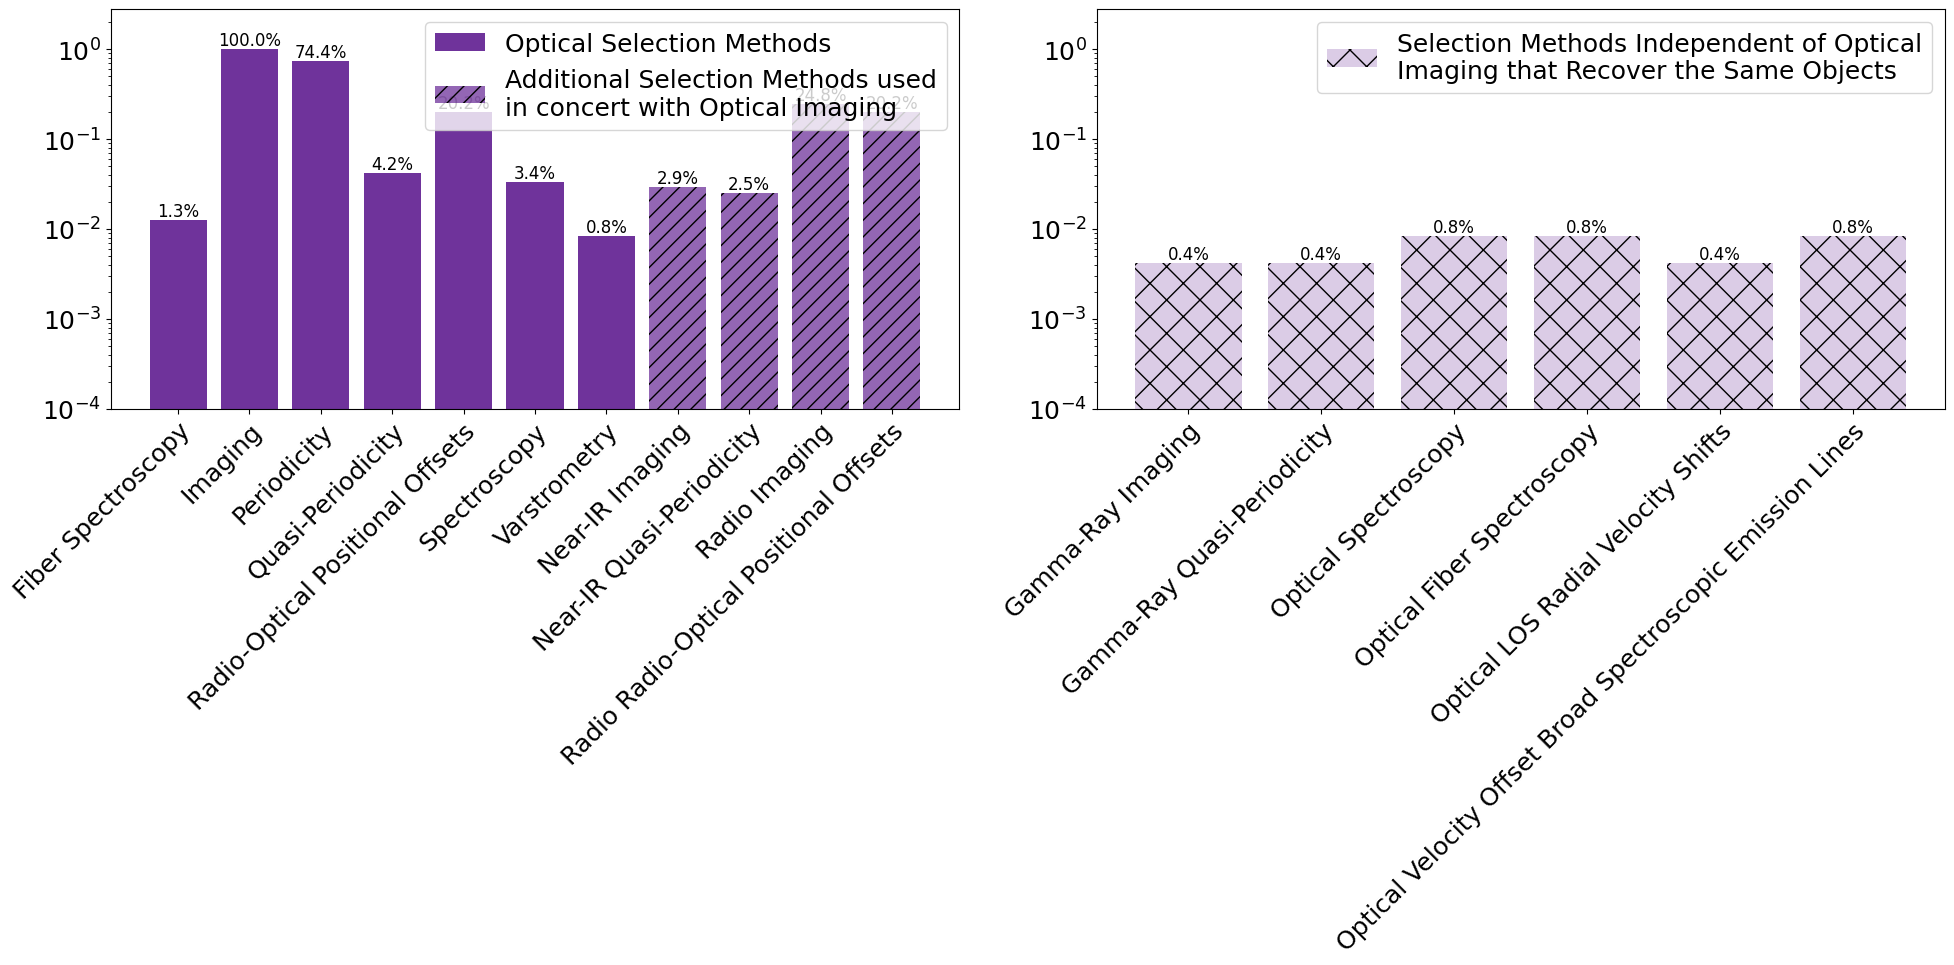

In [8]:
# here we're testing out the plotting for objects that have optical spectroscopy as a selection technique
#('Gamma-Ray', 'Quasi-Periodicity')*
#('Near-IR', 'Quasi-Periodicity') *
#('Optical', 'Colors')
#('Optical', 'Double-Peaked Broad Spectroscopic Emission Lines')
#('Optical', 'Double-Peaked Spectroscopic Emission Lines')
#('Optical', 'Fiber Spectroscopy')
#('Optical', 'Imaging')
#('Optical', 'LOS Radial Velocity Shifts')
#('Optical', 'Periodicity')
#('Optical', 'Positional Offset')
#('Optical', 'Quasi-Periodicity')
#('Optical', 'Radio-Optical Positional Offsets')
#('Optical', 'Spectroscopic Emission Line Ratios')
#('Optical', 'Spectroscopy')
#('Optical', 'Varstrometry')
#('Optical', 'Velocity Offset Broad Spectroscopic Emission Lines')
#('Radio', 'Imaging') *
#('Radio', 'Jet Precession') *
#('Radio', 'Radio-Optical Positional Offsets') *
#('Radio', 'X-Shaped Source') *

band = ['Optical']
tech = ['Fiber Spectroscopy','Imaging','Periodicity',\
        'Quasi-Periodicity','Radio-Optical Positional Offsets',\
        'Spectroscopy','Varstrometry'] #,'Velocity Offset Broad Spectroscopic Emission Lines']  'LOS Radial Velocity Shifts',
#'Double-Peaked Broad Spectroscopic Emission Lines','Double-Peaked Spectroscopic Emission Lines','Spectroscopic Emission Line Ratios',
band2 = ['Near-IR']
tech2 = ['Imaging','Quasi-Periodicity']
band3 = ['Gamma-Ray']
tech3 = ['Imaging','Quasi-Periodicity']
band6 = ['Radio']
tech6 = ['Imaging','Radio-Optical Positional Offsets'] #'Double Sources','Radio-Optical Positional Offsets','X-Shaped Source'
#'Jet Precession','X-Shaped Source',

bars = tech
num = []

filter_selection = get_selection_method('Optical', 'Imaging')
gandalf = MAC2[MAC2.apply(filter_selection, axis=1)]

# we have to drop the objects improperly selected via optical spectroscopy...
names = ['SDSSJ152806.63+132345.8 / J1528+1323','Ark 120','142314.18+505537.2 / SBS 1421+511 QSO','E1821+643']
for i in names:
    for index, row in gandalf.iterrows():
        if row['Name1']==str(i):
            gandalf.drop(index, inplace=True)
    
print(len(gandalf))
norm = len(gandalf)

# tally to remove from main chart

for i in band:
    for j in tech:
        filter_selection = get_selection_method(str(i), str(j))
        df_selection = gandalf[gandalf.apply(filter_selection, axis=1)]
        if j=='Imaging':
            num.append((len(df_selection))/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='Periodicity':
            num.append((len(df_selection))/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='LOS Radial Velocity Shifts':
            num.append((len(df_selection))/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='Spectroscopy':
            num.append((len(df_selection)-2)/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='Fiber Spectroscopy':
            num.append((len(df_selection)-2)/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        elif j=='Spectroscopic Emission Line Ratios':
            num.append((len(df_selection))/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))
        else:
            num.append(len(df_selection)/norm) 
            print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j))

for i in tech:
    techadd.append('Optical '+str(i))
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
plt.rcParams.update({'font.size': 18})

#ax1.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Radio Selection Methods')

bars = ax1.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Optical Selection Methods')
for bar in bars:
    height = bar.get_height()
    if height>0.0001:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

   

techadd=[]
num=[]
for k in band2:
    for m in tech2:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        num.append(len(df_selection2)/norm)
        print(str(len(df_selection2)) + ' ' + str(k) + ' ' + str(m))

for i in tech2:
    techadd.append('Near-IR '+str(i))

#for k in band3:
#    for m in tech3:
#        filter_selection = get_selection_method(str(k), str(m))
#        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
#        num.append(len(df_selection2)/norm)
#        print(str(len(df_selection2)) + ' ' + str(k) + ' ' + str(m))
#
#for i in tech3:
#    techadd.append('Gamma-Ray '+str(i))



for k in band6:
    for m in tech6:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        if m=='Imaging':
            num.append((len(df_selection2))/norm)
            print(str(len(df_selection2)) + ' ' + str(k) + ' ' + str(m))
        elif m=='Jet Precession':
            num.append((len(df_selection2))/norm)
            print(str(len(df_selection2)) + ' ' + str(k) + ' ' + str(m))
        else:
            num.append((len(df_selection2))/norm)
            print(str(len(df_selection2)) + ' ' + str(k) + ' ' + str(m))

for i in tech6:
    techadd.append('Radio '+str(i))
    

bars = ax1.bar(techadd, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.6, hatch='//', label='Additional Selection Methods used\nin concert with Optical Imaging')
#xlabels =  ax1.get_xticklabels()
ax1.set_xticklabels(tech+techadd, rotation=45, ha='right', rotation_mode='anchor')
#ax1.text(0.2, 0.9, 'Object Class: Dual AGN/SMBH Candidates\nSelection Breakdown: Radio Imaging', transform=ax1.transAxes, fontsize=18)

for bar in bars:
    height = bar.get_height()
    if height>0.0001:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

ax1.legend()


# the second bar chart will go below here...
# tally to add to second chart


# subtract optical spec  for 2
# subtract fiber spec for 2, add to second chart for 2 and add 2 opt spec

# subtract 1  LOS Radial Velocity Shiftsfrom list, add to second chart one time
# remove ,Optical Velocity Offset Broad Spectroscopic Emission Lines add both to second chart

#near-IR is in concert with optical keep on cjhart 1

# gamma ray is independnet put 1 object on second chart


tech = ['Gamma-Ray Imaging','Gamma-Ray Quasi-Periodicity','Optical Spectroscopy','Optical Fiber Spectroscopy','Optical LOS Radial Velocity Shifts',\
       'Optical Velocity Offset Broad Spectroscopic Emission Lines']
num = [1/norm,1/norm,2/norm,2/norm,1/norm,2/norm]


bars = ax2.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.2, hatch='x', label='Selection Methods Independent of Optical\nImaging that Recover the Same Objects')
xlabels = ax2.get_xticklabels()
ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
ax2.legend()

for bar in bars:
    height = bar.get_height()
    if height>0.0001:
        percentage = f'{100*height:.1f}%'
        ax2.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)

ax1.set_ylim([0.0001, 2.8]) 
ax2.set_ylim([0.0001, 2.8]) 

plt.tight_layout()
plt.savefig('binaryagn_breakdown_optimaging.pdf', dpi=150)
plt.show()



In [18]:
g1 = gandalf.copy()
#for index, row in g1.iterrows():
#    if 'UV Spectroscopy' not in row['Processed Selection Method']:
#        g1.drop(index, inplace=True)

g1 = g1[g1['Processed Selection Method'].str.contains('Optical Fiber Spectroscopy', na=False)]

g1[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]




Name1  \
1374  SDSSJ081617.73+293639.6   
1528          RXS J10304+5516   
2942         J1536+0441 VLA-A   
3092          SDSS J0159+0105   
3489      J100601.74+345410.5   

                                               Paper(s)  \
1374                Inada+2008 ; Graham+2015 ; Guo+2020   
1528                  Graham+2015 ; Guo+2020 ; Liu+2014   
2942  Boroson+2009 ; Chornock+2009 ; Wrobel+2009 ; L...   
3092                                         Zheng+2016   
3489                               Ge+2012 ; Orosz+2013   

                               Primary System Type  \
1374                            Dual AGN Candidate   
1528  Binary AGN Candidate ; Binary SMBH Candidate   
2942                            Dual AGN Candidate   
3092                          Binary AGN Candidate   
3489                            Dual AGN Candidate   

                             Secondary System Type Tertiary System Type  \
1374  Binary AGN Candidate ; Binary SMBH Candidate                  -99   
1528                                           -99                  -99   
2942  Binary AGN Candidate ; Binary SMBH Candidate                  -99   
3092                                           -99                  -99   
3489                          Binary AGN Candidate                  -99   

                                Parsed Selection Method  \
1374  {'Optical': ['Colors', 'Fiber Spectroscopy', '...   
1528  {'Optical': ['Fiber Spectroscopy', 'Imaging', ...   
2942  {'Optical': ['Fiber Spectroscopy', 'Imaging', ...   
3092  {'Optical': ['Fiber Spectroscopy', 'Periodicit...   
3489  {'Optical': ['Double-Peaked Spectroscopic Emis...   

                                 Parsed Analysis Method  \
1374  {'Optical': ['Colors', 'Fiber Spectroscopy', '...   
1528  {'Optical': ['Fiber Spectroscopy', 'Imaging', ...   
2942  {'Optical': ['Fiber Spectroscopy', 'Imaging', ...   
3092  {'Optical': ['Fiber Spectroscopy', 'Periodicit...   
3489  {'Optical': ['Double-Peaked Spectroscopic Emis...   

     Parsed Confirmation Method  
1374                         {}  
1528                         {}  
2942                         {}  
3092                         {}  
3489                         {}

In [ ]:
test = gandalf.copy()
for index, row in gandalf.iterrows():
    if 'Optical Imaging' not in row['Processed Selection Method']:
        test.drop(index, inplace=True)

test[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]

#throw out
#J083127.50+321926.9 / B2 0828+32
#J094124+394441 / 3C223.1
#J100601.74+345410.5
#J161847.93+215925.4
#J003636.21+004853.45
#J155416.08+381132.64
#J091405.28+171554.36
#J131638.16+242732.40
#J014719.27-085119.58
#J011341.11+010608.50



In [ ]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('Radio', 'Imaging')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
#df_selection['Parsed Selection Method'].unique()


In [ ]:
data = df_selection['Parsed Selection Method'].unique()
dicts = [ast.literal_eval(d) for d in data]

# Step 2: Aggregate all entries into a single list
all_entries = []
for d in dicts:
    for key, values in d.items():
        for value in values:
            all_entries.append((key, value))

# Step 3: Remove duplicates by converting list of tuples into a set
unique_entries = set(all_entries)

# Optionally, convert back to list of dictionaries or keep as list of tuples
#unique_dicts = [{k: v} for k, v in unique_entries]

#print(unique_dicts)
unique_entries_list = list(unique_entries)

# Sort the list by the first element of each tuple (the key) and then by the second element (the value)
sorted_unique_entries = sorted(unique_entries_list, key=lambda x: (x[0], x[1]))

for i in sorted_unique_entries:
    print(i)

610
Radio Imaging 610
Radio Jet Precession 35
Radio X-Shaped Source 507
Radio Radio-Optical Positional Offsets 48
Radio Periodicity 10
Radio Quasi-Periodicity 6
Radio Double Sources 4
Radio Double Jet 4


/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_66356/3823410866.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_66356/3823410866.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(tech+techadd, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_66356/3823410866.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')


Optical Double-Peaked Broad Spectroscopic Emission Lines 4
Optical Double-Peaked Spectroscopic Emission Lines 11
Optical Fiber Spectroscopy 15
Optical Imaging 61
Optical Periodicity 8
Optical Quasi-Periodicity 5
Optical Radio-Optical Positional Offsets 48
Optical Spectroscopic Emission Line Ratios 11
Optical Spectroscopy 22
Optical Velocity Offset Broad Spectroscopic Emission Lines 4
Near-IR Imaging 3
Near-IR Quasi-Periodicity 2


/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_66356/3823410866.py:197: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')


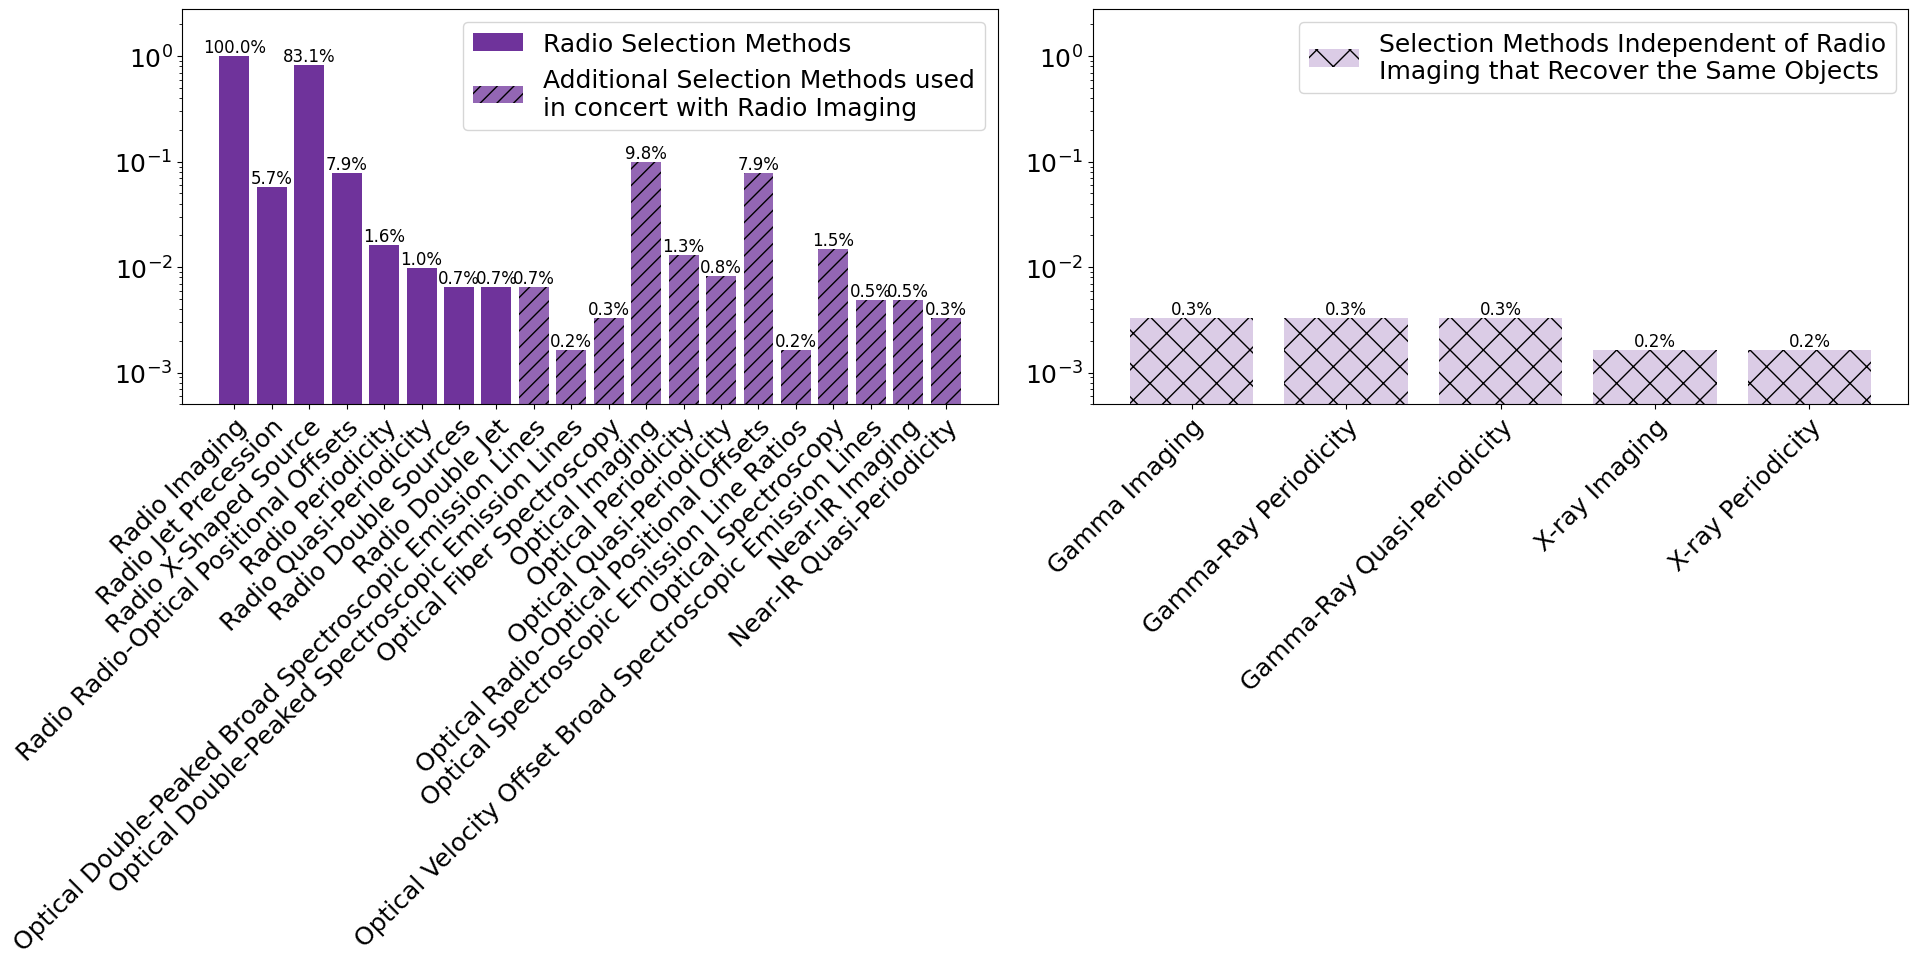

In [17]:
# and here, focusing on radio imaging
#('Gamma-Ray', 'Periodicity') *
#('Gamma-Ray', 'Quasi-Periodicity') *
#('Near-IR', 'Quasi-Periodicity') *
#('Optical', 'Colors')
#('Optical', 'Double-Peaked Broad Spectroscopic Emission Lines')
#('Optical', 'Double-Peaked Spectroscopic Emission Lines')
#('Optical', 'Fiber Spectroscopy')
#('Optical', 'Imaging')
#('Optical', 'Periodicity')
#('Optical', 'Quasi-Periodicity')
#('Optical', 'Radio-Optical Positional Offsets')
#('Optical', 'Spectroscopic Emission Line Ratios')
#('Optical', 'Spectroscopy')
#('Optical', 'Velocity Offset Broad Spectroscopic Emission Lines')
#('Optical', 'Velocity Offset Narrow Spectroscopic Emission Lines')
#('Radio', 'Double Jet') *
#('Radio', 'Double Sources') *
#('Radio', 'Imaging') *
#('Radio', 'Jet Precession') *
#('Radio', 'Periodicity') *
#('Radio', 'Quasi-Periodicity') *
#('Radio', 'Radio-Optical Positional Offsets') *
#('Radio', 'X-Shaped Source') *
#('X-ray', 'Periodicity') *
#('X-ray', 'Quasi-Periodicity') *

band = ['Radio']
tech1 = ['Imaging','Jet Precession','X-Shaped Source','Radio-Optical Positional Offsets',\
         'Periodicity','Quasi-Periodicity','Double Sources','Double Jet'] #'X-Shaped Source'

band2 = ['Optical']
tech2 = ['Double-Peaked Broad Spectroscopic Emission Lines','Double-Peaked Spectroscopic Emission Lines',\
         'Fiber Spectroscopy','Imaging','Periodicity','Quasi-Periodicity','Radio-Optical Positional Offsets',\
         'Spectroscopic Emission Line Ratios','Spectroscopy','Velocity Offset Broad Spectroscopic Emission Lines'] 
band3 = ['X-ray']
tech3 = ['Imaging','Periodicity','Quasi-Periodicity']
#band3 = ['Hard X-ray']
#tech3 = ['BAT Selection']
band4 = ['Near-IR']
tech4 = ['Imaging','Quasi-Periodicity']
band5 = ['Gamma-Ray']
tech5 = ['Imaging','Periodicity','Quasi-Periodicity']
#band6 = ['X-ray']
#tech6 = ['Imaging']
#band7 = ['Infrared']
#tech7 = ['Imaging','Radio-Infrared Colors']

bars = tech1
num = []

filter_selection = get_selection_method('Radio', 'Imaging')
gandalf = MAC2[MAC2.apply(filter_selection, axis=1)]
        
print(len(gandalf))
norm = len(gandalf)

for i in band:
    for j in tech1:
        filter_selection = get_selection_method(str(i), str(j))
        df_selection = gandalf[gandalf.apply(filter_selection, axis=1)]
        num.append(len(df_selection)/norm)    
        print(str(i)+' '+str(j)+' '+str(len(df_selection)))

tech = []
for i in tech1:
    tech.append('Radio '+str(i))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
plt.rcParams.update({'font.size': 18})

#ax1.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Radio Selection Methods')

bars = ax1.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Radio Selection Methods')
for bar in bars:
    height = bar.get_height()
    if height>0.:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

techadd=[]
num=[]

# optical spec: 13 not used for binary *
# fiber spec:12 not used for binary *
# double peak: 10 not used  *
# spec ratios: 10 not used *
# Optical Velocity Offset Broad Spectroscopic Emission Lines: 1 not used *
# remove optical colors and 1 optical imaging *
for k in band2:
    for m in tech2:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        if m=='Spectroscopy':
            num.append((len(df_selection2)-13)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Fiber Spectroscopy':
            num.append((len(df_selection2)-13)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Imaging':
            num.append((len(df_selection2)-1)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Velocity Offset Broad Spectroscopic Emission Lines':
            num.append((len(df_selection2)-1)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Spectroscopic Emission Line Ratios':
            num.append((len(df_selection2)-10)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Double-Peaked Spectroscopic Emission Lines':
            num.append((len(df_selection2)-10)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        else:
            num.append(len(df_selection2)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))

for i in tech2:
    techadd.append('Optical '+str(i))

#for k in band3:
#    for m in tech3:
#        filter_selection = get_selection_method(str(k), str(m))
#        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
#        num.append(len(df_selection2)/norm)
#        print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
#        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
#        # added a for loop here to remove the numbers of objects that shiould be in tehe second panel
#        
#for i in tech3:
#    techadd.append('X-ray '+str(i))
#
#
for k in band4:
    for m in tech4:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        num.append(len(df_selection2)/norm)
        print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
        # added a for loop here to remove the numbers of objects that shiould be in tehe second panel
        
for i in tech4:
    techadd.append('Near-IR '+str(i))

#for k in band5:
#    for m in tech5:
#        filter_selection = get_selection_method(str(k), str(m))
#        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
#        num.append(len(df_selection2)/norm)
#        print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
#        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
#        # added a for loop here to remove the numbers of objects that shiould be in tehe second panel
#        
#for i in tech5:
#    techadd.append('Gamma-Ray '+str(i))


bars = ax1.bar(techadd, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.6, hatch='//', label='Additional Selection Methods used\nin concert with Radio Imaging')
#xlabels =  ax1.get_xticklabels()
ax1.set_xticklabels(tech+techadd, rotation=45, ha='right', rotation_mode='anchor')
#ax1.text(0.2, 0.9, 'Object Class: Dual AGN/SMBH Candidates\nSelection Breakdown: Radio Imaging', transform=ax1.transAxes, fontsize=18)

for bar in bars:
    height = bar.get_height()
    if height>0:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

ax1.legend()
# and down below here we'll focus on the methods that are independent of radio imaigng

# Xray imaging and periodicity (1) is independent

# gamma ray  periodicity
# remove all and add 2 to the second chart (noting that for BL LAC  we're removing gamma ray periodicity as select meth)
# note to self: sandrinelli 2017 lookedt gamma ray periodicity of BL LAC but I think this was motoivated by the earlier study at other \
# wavelengths, so we should prob remove gamma ray periodicity from selection method \
# and add as an analysis methodf....

# same for quasi periodicity


# near-IR periodicity used in concertwith optical oimaging and periodicityu


tech = ['Gamma Imaging','Gamma-Ray Periodicity','Gamma-Ray Quasi-Periodicity','X-ray Imaging','X-ray Periodicity']
num = [2/norm,2/norm,2/norm,1/norm,1/norm]

bars = ax2.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.2, hatch='x', label='Selection Methods Independent of Radio\nImaging that Recover the Same Objects')
xlabels = ax2.get_xticklabels()
ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
ax2.legend()

for bar in bars:
    height = bar.get_height()
    if height>0:
        percentage = f'{100*height:.1f}%'
        ax2.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)

ax1.set_ylim([0.0005, 2.8]) 
ax2.set_ylim([0.0005, 2.8]) 

plt.tight_layout()
plt.savefig('binaryagn_breakdown_radioimaging.pdf', dpi=150)
plt.show()



In [ ]:
gandalf = gandalf[(gandalf['Paper(s)']!='Proctor+2011') & \
                 (gandalf['Paper(s)']!='Yang+2019') & \
                 (gandalf['Paper(s)']!='Yang+2019 ; Joshi+2019') & \
                 (gandalf['Paper(s)']!='Proctor+2011 ; Yang+2019 ; Joshi+2019') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018') & \
                 (gandalf['Paper(s)']!='Proctor+2011 ; Yang+2019') & \
                  (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Proctor+2011 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018 ; Lal+2019') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Proctor+2011 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018 ; Lal+2019') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                 (gandalf['Paper(s)']!='Orosz+2013')]

print(len(gandalf))
gandalf[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]


#Optical Periodicity 3
#Optical Quasi-Periodicity 3



In [ ]:
test = gandalf.copy()
for index, row in gandalf.iterrows():
    if 'Optical Quasi-Periodicity' not in row['Processed Selection Method']:
        test.drop(index, inplace=True)

test[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]

# Xray imaging and periodicity (1) is independent

# gamma ray  periodicity
# remove all and add 2 to the second chart (noting that for BL LAC  we're removing gamma ray periodicity as select meth)
# note to self: sandrinelli 2017 lookedt gamma ray periodicity of BL LAC but I think this was motoivated by the earlier study at other \
# wavelengths, so we should prob remove gamma ray periodicity from selection method \
# and add as an analysis methodf....

# same for quasi periodicity


# near-IR periodicity used in concertwith optical oimaging and periodicityu




In [ ]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('Radio', 'Imaging')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
#df_selection['Parsed Selection Method'].unique()


In [ ]:
data = df_selection['Parsed Selection Method'].unique()
dicts = [ast.literal_eval(d) for d in data]

# Step 2: Aggregate all entries into a single list
all_entries = []
for d in dicts:
    for key, values in d.items():
        for value in values:
            all_entries.append((key, value))

# Step 3: Remove duplicates by converting list of tuples into a set
unique_entries = set(all_entries)

# Optionally, convert back to list of dictionaries or keep as list of tuples
#unique_dicts = [{k: v} for k, v in unique_entries]

#print(unique_dicts)
unique_entries_list = list(unique_entries)

# Sort the list by the first element of each tuple (the key) and then by the second element (the value)
sorted_unique_entries = sorted(unique_entries_list, key=lambda x: (x[0], x[1]))

for i in sorted_unique_entries:
    print(i)

610
Radio Imaging 610
Radio Jet Precession 35
Radio X-Shaped Source 507
Radio Radio-Optical Positional Offsets 48
Radio Periodicity 10
Radio Quasi-Periodicity 6
Radio Double Sources 4
Radio Double Jet 4


/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_66356/3823410866.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_66356/3823410866.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(tech+techadd, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_66356/3823410866.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_66356/3823410866.py:197: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')


Optical Double-Peaked Broad Spectroscopic Emission Lines 4
Optical Double-Peaked Spectroscopic Emission Lines 11
Optical Fiber Spectroscopy 15
Optical Imaging 61
Optical Periodicity 8
Optical Quasi-Periodicity 5
Optical Radio-Optical Positional Offsets 48
Optical Spectroscopic Emission Line Ratios 11
Optical Spectroscopy 22
Optical Velocity Offset Broad Spectroscopic Emission Lines 4
Near-IR Imaging 3
Near-IR Quasi-Periodicity 2


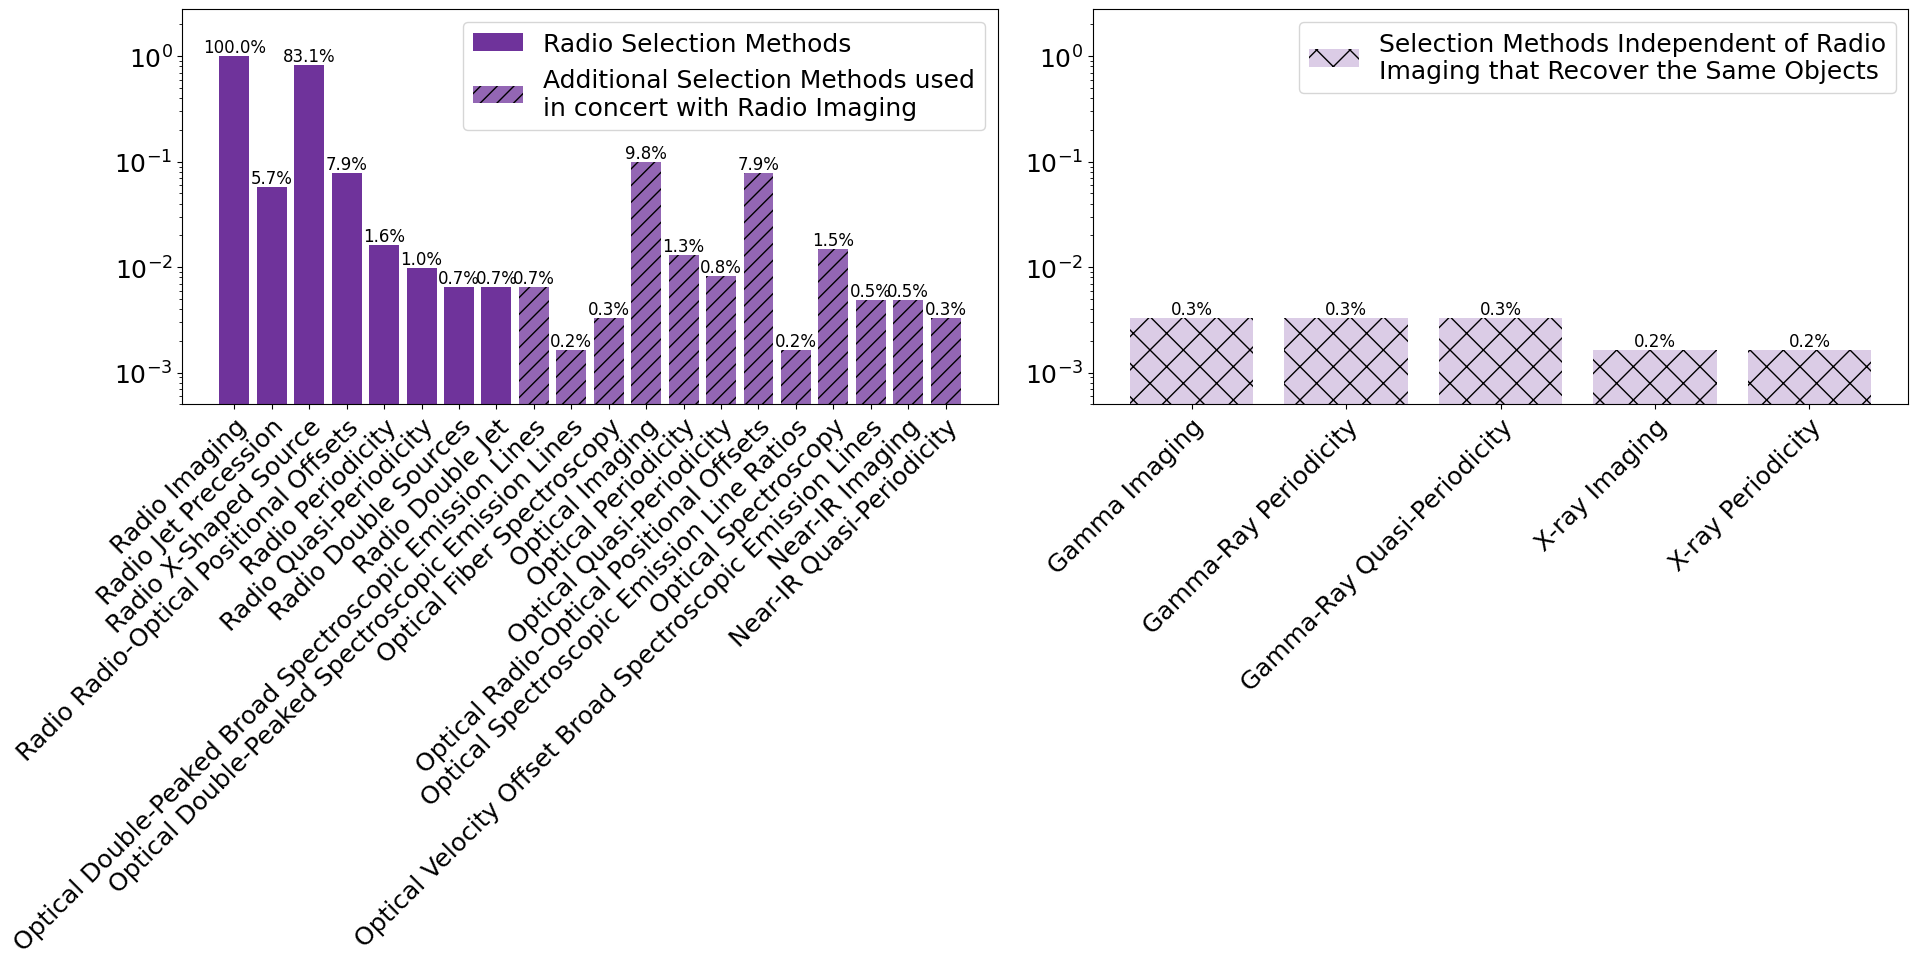

In [18]:
# and here, focusing on radio imaging
#('Gamma-Ray', 'Periodicity') *
#('Gamma-Ray', 'Quasi-Periodicity') *
#('Near-IR', 'Quasi-Periodicity') *
#('Optical', 'Colors')
#('Optical', 'Double-Peaked Broad Spectroscopic Emission Lines')
#('Optical', 'Double-Peaked Spectroscopic Emission Lines')
#('Optical', 'Fiber Spectroscopy')
#('Optical', 'Imaging')
#('Optical', 'Periodicity')
#('Optical', 'Quasi-Periodicity')
#('Optical', 'Radio-Optical Positional Offsets')
#('Optical', 'Spectroscopic Emission Line Ratios')
#('Optical', 'Spectroscopy')
#('Optical', 'Velocity Offset Broad Spectroscopic Emission Lines')
#('Optical', 'Velocity Offset Narrow Spectroscopic Emission Lines')
#('Radio', 'Double Jet') *
#('Radio', 'Double Sources') *
#('Radio', 'Imaging') *
#('Radio', 'Jet Precession') *
#('Radio', 'Periodicity') *
#('Radio', 'Quasi-Periodicity') *
#('Radio', 'Radio-Optical Positional Offsets') *
#('Radio', 'X-Shaped Source') *
#('X-ray', 'Periodicity') *
#('X-ray', 'Quasi-Periodicity') *

band = ['Radio']
tech1 = ['Imaging','Jet Precession','X-Shaped Source','Radio-Optical Positional Offsets',\
         'Periodicity','Quasi-Periodicity','Double Sources','Double Jet'] #'X-Shaped Source'

band2 = ['Optical']
tech2 = ['Double-Peaked Broad Spectroscopic Emission Lines','Double-Peaked Spectroscopic Emission Lines',\
         'Fiber Spectroscopy','Imaging','Periodicity','Quasi-Periodicity','Radio-Optical Positional Offsets',\
         'Spectroscopic Emission Line Ratios','Spectroscopy','Velocity Offset Broad Spectroscopic Emission Lines'] 
band3 = ['X-ray']
tech3 = ['Imaging','Periodicity','Quasi-Periodicity']
#band3 = ['Hard X-ray']
#tech3 = ['BAT Selection']
band4 = ['Near-IR']
tech4 = ['Imaging','Quasi-Periodicity']
band5 = ['Gamma-Ray']
tech5 = ['Imaging','Periodicity','Quasi-Periodicity']
#band6 = ['X-ray']
#tech6 = ['Imaging']
#band7 = ['Infrared']
#tech7 = ['Imaging','Radio-Infrared Colors']

bars = tech1
num = []

filter_selection = get_selection_method('Radio', 'Imaging')
gandalf = MAC2[MAC2.apply(filter_selection, axis=1)]
        
print(len(gandalf))
norm = len(gandalf)

for i in band:
    for j in tech1:
        filter_selection = get_selection_method(str(i), str(j))
        df_selection = gandalf[gandalf.apply(filter_selection, axis=1)]
        num.append(len(df_selection)/norm)    
        print(str(i)+' '+str(j)+' '+str(len(df_selection)))

tech = []
for i in tech1:
    tech.append('Radio '+str(i))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
plt.rcParams.update({'font.size': 18})

#ax1.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Radio Selection Methods')

bars = ax1.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Radio Selection Methods')
for bar in bars:
    height = bar.get_height()
    if height>0.:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

techadd=[]
num=[]

# optical spec: 13 not used for binary *
# fiber spec:12 not used for binary *
# double peak: 10 not used  *
# spec ratios: 10 not used *
# Optical Velocity Offset Broad Spectroscopic Emission Lines: 1 not used *
# remove optical colors and 1 optical imaging *
for k in band2:
    for m in tech2:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        if m=='Spectroscopy':
            num.append((len(df_selection2)-13)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Fiber Spectroscopy':
            num.append((len(df_selection2)-13)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Imaging':
            num.append((len(df_selection2)-1)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Velocity Offset Broad Spectroscopic Emission Lines':
            num.append((len(df_selection2)-1)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Spectroscopic Emission Line Ratios':
            num.append((len(df_selection2)-10)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Double-Peaked Spectroscopic Emission Lines':
            num.append((len(df_selection2)-10)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        else:
            num.append(len(df_selection2)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))

for i in tech2:
    techadd.append('Optical '+str(i))

#for k in band3:
#    for m in tech3:
#        filter_selection = get_selection_method(str(k), str(m))
#        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
#        num.append(len(df_selection2)/norm)
#        print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
#        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
#        # added a for loop here to remove the numbers of objects that shiould be in tehe second panel
#        
#for i in tech3:
#    techadd.append('X-ray '+str(i))
#
#
for k in band4:
    for m in tech4:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        num.append(len(df_selection2)/norm)
        print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
        # added a for loop here to remove the numbers of objects that shiould be in tehe second panel
        
for i in tech4:
    techadd.append('Near-IR '+str(i))

#for k in band5:
#    for m in tech5:
#        filter_selection = get_selection_method(str(k), str(m))
#        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
#        num.append(len(df_selection2)/norm)
#        print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
#        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
#        # added a for loop here to remove the numbers of objects that shiould be in tehe second panel
#        
#for i in tech5:
#    techadd.append('Gamma-Ray '+str(i))


bars = ax1.bar(techadd, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.6, hatch='//', label='Additional Selection Methods used\nin concert with Radio Imaging')
#xlabels =  ax1.get_xticklabels()
ax1.set_xticklabels(tech+techadd, rotation=45, ha='right', rotation_mode='anchor')
#ax1.text(0.2, 0.9, 'Object Class: Dual AGN/SMBH Candidates\nSelection Breakdown: Radio Imaging', transform=ax1.transAxes, fontsize=18)

for bar in bars:
    height = bar.get_height()
    if height>0:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

ax1.legend()
# and down below here we'll focus on the methods that are independent of radio imaigng

# Xray imaging and periodicity (1) is independent

# gamma ray  periodicity
# remove all and add 2 to the second chart (noting that for BL LAC  we're removing gamma ray periodicity as select meth)
# note to self: sandrinelli 2017 lookedt gamma ray periodicity of BL LAC but I think this was motoivated by the earlier study at other \
# wavelengths, so we should prob remove gamma ray periodicity from selection method \
# and add as an analysis methodf....

# same for quasi periodicity


# near-IR periodicity used in concertwith optical oimaging and periodicityu


tech = ['Gamma Imaging','Gamma-Ray Periodicity','Gamma-Ray Quasi-Periodicity','X-ray Imaging','X-ray Periodicity']
num = [2/norm,2/norm,2/norm,1/norm,1/norm]

bars = ax2.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.2, hatch='x', label='Selection Methods Independent of Radio\nImaging that Recover the Same Objects')
xlabels = ax2.get_xticklabels()
ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
ax2.legend()

for bar in bars:
    height = bar.get_height()
    if height>0:
        percentage = f'{100*height:.1f}%'
        ax2.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)

ax1.set_ylim([0.0005, 2.8]) 
ax2.set_ylim([0.0005, 2.8]) 

plt.tight_layout()
plt.savefig('binaryagn_breakdown_radioimaging.pdf', dpi=150)
plt.show()



In [ ]:
gandalf = gandalf[(gandalf['Paper(s)']!='Proctor+2011') & \
                 (gandalf['Paper(s)']!='Yang+2019') & \
                 (gandalf['Paper(s)']!='Yang+2019 ; Joshi+2019') & \
                 (gandalf['Paper(s)']!='Proctor+2011 ; Yang+2019 ; Joshi+2019') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018') & \
                 (gandalf['Paper(s)']!='Proctor+2011 ; Yang+2019') & \
                  (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Proctor+2011 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018 ; Lal+2019') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Proctor+2011 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018 ; Lal+2019') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                 (gandalf['Paper(s)']!='Orosz+2013')]

print(len(gandalf))
gandalf[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]


#Optical Periodicity 3
#Optical Quasi-Periodicity 3



In [ ]:
test = gandalf.copy()
for index, row in gandalf.iterrows():
    if 'Optical Quasi-Periodicity' not in row['Processed Selection Method']:
        test.drop(index, inplace=True)

test[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]

# Xray imaging and periodicity (1) is independent

# gamma ray  periodicity
# remove all and add 2 to the second chart (noting that for BL LAC  we're removing gamma ray periodicity as select meth)
# note to self: sandrinelli 2017 lookedt gamma ray periodicity of BL LAC but I think this was motoivated by the earlier study at other \
# wavelengths, so we should prob remove gamma ray periodicity from selection method \
# and add as an analysis methodf....

# same for quasi periodicity


# near-IR periodicity used in concertwith optical oimaging and periodicityu




In [6]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('Gamma-Ray', 'Imaging')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
len(df_selection)
#df_selection['Parsed Selection Method'].unique()


15

In [7]:
data = df_selection['Parsed Selection Method'].unique()
dicts = [ast.literal_eval(d) for d in data]

# Step 2: Aggregate all entries into a single list
all_entries = []
for d in dicts:
    for key, values in d.items():
        for value in values:
            all_entries.append((key, value))

# Step 3: Remove duplicates by converting list of tuples into a set
unique_entries = set(all_entries)

# Optionally, convert back to list of dictionaries or keep as list of tuples
#unique_dicts = [{k: v} for k, v in unique_entries]

#print(unique_dicts)
unique_entries_list = list(unique_entries)

# Sort the list by the first element of each tuple (the key) and then by the second element (the value)
sorted_unique_entries = sorted(unique_entries_list, key=lambda x: (x[0], x[1]))

for i in sorted_unique_entries:
    print(i)

('Gamma-Ray', 'Imaging')
('Gamma-Ray', 'Periodicity')
('Gamma-Ray', 'Quasi-Periodicity')
('Near-IR', 'Imaging')
('Near-IR', 'Quasi-Periodicity')
('Optical', 'Imaging')
('Optical', 'Periodicity')
('Optical', 'Quasi-Periodicity')
('Radio', 'Double Jet')
('Radio', 'Double Sources')
('Radio', 'Imaging')
('Radio', 'Jet Precession')
('Radio', 'Periodicity')
('Radio', 'Quasi-Periodicity')
('X-ray', 'Imaging')
('X-ray', 'Periodicity')
('X-ray', 'Quasi-Periodicity')


15
Gamma-Ray Imaging 15
Gamma-Ray Periodicity 3
Gamma-Ray Quasi-Periodicity 14
Optical Imaging 7
Optical Periodicity 1
Optical Quasi-Periodicity 6
X-ray Imaging 2
X-ray Periodicity 1
X-ray Quasi-Periodicity 1
Near-IR Imaging 3
Near-IR Quasi-Periodicity 3
Radio Imaging 5
Radio Jet Precession 3
Radio Periodicity 2
Radio Quasi-Periodicity 2
Radio Double Sources 1


/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_34210/2058618104.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_34210/2058618104.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(tech+techadd, rotation=45, ha='right', rotation_mode='anchor')
/var/folders/_n/4v22wftn7354wlkmn_g7rtdr0000gn/T/ipykernel_34210/2058618104.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')


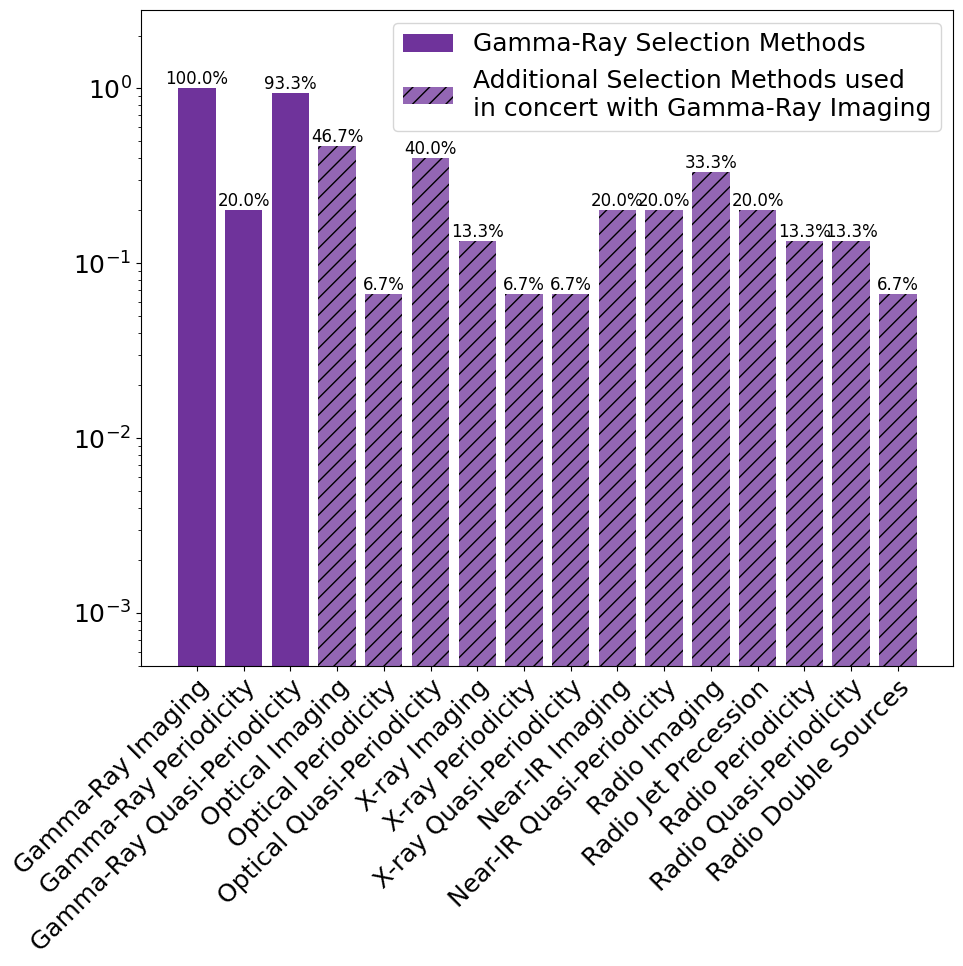

In [9]:
# and here, focusing on radio imaging
#('Gamma-Ray', 'Periodicity') *
#('Gamma-Ray', 'Quasi-Periodicity') *
#('Near-IR', 'Quasi-Periodicity') *
#('Optical', 'Imaging') *
#('Optical', 'Quasi-Periodicity') *
#('Radio', 'Double Sources') *
#('Radio', 'Imaging') *
#('Radio', 'Jet Precession') *
#('Radio', 'Periodicity') *
#('Radio', 'Quasi-Periodicity') *
#('X-ray', 'Periodicity') *
#('X-ray', 'Quasi-Periodicity') *

band = ['Gamma-Ray']
tech1 = ['Imaging','Periodicity','Quasi-Periodicity']

band2 = ['Optical']
tech2 = ['Imaging','Periodicity','Quasi-Periodicity'] 
band3 = ['X-ray']
tech3 = ['Imaging','Periodicity','Quasi-Periodicity']
#band3 = ['Hard X-ray']
#tech3 = ['BAT Selection']
band4 = ['Near-IR']
tech4 = ['Imaging','Quasi-Periodicity']

band5 = ['Radio']
tech5 = ['Imaging','Jet Precession','Periodicity','Quasi-Periodicity','Double Sources'] 

bars = tech1
num = []

filter_selection = get_selection_method('Gamma-Ray', 'Imaging')
gandalf = MAC2[MAC2.apply(filter_selection, axis=1)]
        
print(len(gandalf))
norm = len(gandalf)

for i in band:
    for j in tech1:
        filter_selection = get_selection_method(str(i), str(j))
        df_selection = gandalf[gandalf.apply(filter_selection, axis=1)]
        num.append(len(df_selection)/norm)    
        print(str(i)+' '+str(j)+' '+str(len(df_selection)))

tech = []
for i in tech1:
    tech.append('Gamma-Ray '+str(i))

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
plt.rcParams.update({'font.size': 18})

#ax1.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Radio Selection Methods')

bars = ax1.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.8, label='Gamma-Ray Selection Methods')
for bar in bars:
    height = bar.get_height()
    if height>0.:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

techadd=[]
num=[]


for k in band2:
    for m in tech2:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        if m=='Spectroscopy':
            num.append((len(df_selection2))/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Fiber Spectroscopy':
            num.append((len(df_selection2))/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Imaging':
            num.append((len(df_selection2))/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Velocity Offset Broad Spectroscopic Emission Lines':
            num.append((len(df_selection2))/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Spectroscopic Emission Line Ratios':
            num.append((len(df_selection2))/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        elif m=='Double-Peaked Spectroscopic Emission Lines':
            num.append((len(df_selection2))/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        else:
            num.append(len(df_selection2)/norm)
            print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))

for i in tech2:
    techadd.append('Optical '+str(i))

for k in band3:
    for m in tech3:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        num.append(len(df_selection2)/norm)
        print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
        # added a for loop here to remove the numbers of objects that shiould be in tehe second panel
        
for i in tech3:
    techadd.append('X-ray '+str(i))


for k in band4:
    for m in tech4:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        num.append(len(df_selection2)/norm)
        print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
        # added a for loop here to remove the numbers of objects that shiould be in tehe second panel
        
for i in tech4:
    techadd.append('Near-IR '+str(i))

for k in band5:
    for m in tech5:
        filter_selection = get_selection_method(str(k), str(m))
        df_selection2 = gandalf[gandalf.apply(filter_selection, axis=1)] 
        num.append(len(df_selection2)/norm)
        print(str(k)+' '+str(m)+' '+str(len(df_selection2)))
        #print(str(len(df_selection)) + ' ' + str(i) + ' ' + str(j) + ' ' + str(k))
        # added a for loop here to remove the numbers of objects that shiould be in tehe second panel
        
for i in tech5:
    techadd.append('Radio '+str(i))


bars = ax1.bar(techadd, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.6, hatch='//', label='Additional Selection Methods used\nin concert with Gamma-Ray Imaging')
#xlabels =  ax1.get_xticklabels()
ax1.set_xticklabels(tech+techadd, rotation=45, ha='right', rotation_mode='anchor')
#ax1.text(0.2, 0.9, 'Object Class: Dual AGN/SMBH Candidates\nSelection Breakdown: Radio Imaging', transform=ax1.transAxes, fontsize=18)

for bar in bars:
    height = bar.get_height()
    if height>0:
        percentage = f'{100*height:.1f}%'
        ax1.text(bar.get_x() + bar.get_width() / 2, height, percentage,
                ha='center', va='bottom', fontsize=12)
xlabels = ax1.get_xticklabels()
ax1.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

ax1.legend()
#



#tech = []
#num = []
#
#bars = ax2.bar(tech, num, width=0.8, bottom=None, align='center', data=None, log=True, color='indigo', alpha=0.2, hatch='x', label='Selection Methods Independent of Gamma-Ray\nImaging that Recover the Same Objects')
#xlabels = ax2.get_xticklabels()
#ax2.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
#ax2.legend()
#
#for bar in bars:
#    height = bar.get_height()
#    if height>0:
#        percentage = f'{100*height:.1f}%'
#        ax2.text(bar.get_x() + bar.get_width() / 2, height, percentage,
#                ha='center', va='bottom', fontsize=12)
#
ax1.set_ylim([0.0005, 2.8]) 
#ax2.set_ylim([0.0005, 2.8]) 

plt.tight_layout()
plt.savefig('binaryagn_breakdown_gammarayqpo.pdf', dpi=150)
plt.show()



In [10]:
gandalf

Unnamed: 0.1  Unnamed: 0  \
2963          2963        3427   
2970          2970        3434   
2975          2975        3439   
2980          2980        3444   
2981          2981        3445   
2982          2982        3446   
2989          2989        3453   
3013          3013        3477   
3014          3014        3478   
3015          3015        3479   
3016          3016        3480   
3090          3090        3554   
3091          3091        3555   
3094          3094        3558   
3097          3097        3561   

                                          System Type    Literature Name  \
2963  Binary Quasar Candidate / Binary SMBH Candidate       PKS 0537-441   
2970                             Binary AGN Candidate             3C 279   
2975                             Binary AGN Candidate           3C 454.3   
2980                             Binary AGN Candidate             BL LAC   
2981                             Binary AGN Candidate            Mrk 501   
2982                             Binary AGN Candidate       PKS 2155-304   
2989                             Binary AGN Candidate        PG 1553+113   
3013                             Binary AGN Candidate        S5 0716+714   
3014                             Binary AGN Candidate       PKS 0805-077   
3015                             Binary AGN Candidate           4C+01.28   
3016                             Binary AGN Candidate       PKS 2052-474   
3090                             Binary AGN Candidate  3FGL J0449.4-4350   
3091                             Binary AGN Candidate       PKS 0301-243   
3094                             Binary AGN Candidate       PKS 0426-380   
3097                             Binary AGN Candidate       PKS 2247-131   

                                       Selection Method Confirmation Method  \
2963  Optical Imaging / Optical Quasi-Periodicity / ...                 -99   
2970  Radio Imaging / Radio Jet Precession / Modelin...                 -99   
2975  Radio Periodicity / Optical Quasi-Periodicity ...                 -99   
2980  Gamma-Ray Periodicity / Radio Periodicity / Op...                 -99   
2981  Radio Imaging / Gamma-Ray Quasi-Periodicity / ...                 -99   
2982  Modeling / Optical Quasi-Periodicity / Near-IR...                 -99   
2989  Optical Quasi-Periodicity / Radio Quasi-Period...                 -99   
3013                        Gamma-Ray Quasi-Periodicity                 -99   
3014                        Gamma-Ray Quasi-Periodicity                 -99   
3015                        Gamma-Ray Quasi-Periodicity                 -99   
3016                        Gamma-Ray Quasi-Periodicity                 -99   
3090  Gamma-Ray Quasi-Periodicity / Optical Quasi-Pe...                 -99   
3091                        Gamma-Ray Quasi-Periodicity                 -99   
3094                        Gamma-Ray Quasi-Periodicity                 -99   
3097                        Gamma-Ray Quasi-Periodicity                 -99   

                  Name1        z1    z1_type                  RA1  \
2963       PKS 0537-441  0.893000       spec    05:38:50.36155219   
2970             3C 279  0.538000     Simbad    12:56:11.16657958   
2975           3C 454.3  0.859001     Simbad  22:53:57.7480438728   
2980             BL LAC  0.069000     Simbad  22:02:43.2913536816   
2981            Mrk 501  0.034123       spec    16:53:52.21668403   
2982       PKS 2155-304  0.116000     Simbad  21:58:52.0652249880   
2989        PG 1553+113  0.490000        -99  15:55:43.0440048528   
3013        S5 0716+714  0.300000        -99  07:21:53.4482942664   
3014       PKS 0805-077  1.840000       spec    08:08:15.53603763   
3015           4C+01.28  0.185160       spec    10:58:29.60520810   
3016       PKS 2052-474  1.490000       spec    20:56:16.35980507   
3090  3FGL J0449.4-4350  0.205000        -99        04:49:24.690s   
3091       PKS 0301-243  0.266000  Pita+2012           03:03:44.2   
3094       PK

In [ ]:
gandalf = gandalf[(gandalf['Paper(s)']!='Proctor+2011') & \
                 (gandalf['Paper(s)']!='Yang+2019') & \
                 (gandalf['Paper(s)']!='Yang+2019 ; Joshi+2019') & \
                 (gandalf['Paper(s)']!='Proctor+2011 ; Yang+2019 ; Joshi+2019') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018') & \
                 (gandalf['Paper(s)']!='Proctor+2011 ; Yang+2019') & \
                  (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Proctor+2011 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018 ; Lal+2019') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Proctor+2011 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018 ; Lal+2019') & \
                 (gandalf['Paper(s)']!='Cheung+2007 ; Roberts+2018 ; Saripalli+2018 ; Saripalli+2018') & \
                 (gandalf['Paper(s)']!='Orosz+2013')]

print(len(gandalf))
gandalf[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]

#Gamma-Ray Imaging 0
#Gamma-Ray Periodicity 3
#Gamma-Ray Quasi-Periodicity 3
#Optical Imaging 50
#Optical Quasi-Periodicity 3
#X-ray Imaging 0
#
#X-ray Periodicity 1
#X-ray Quasi-Periodicity 1
#Near-IR Imaging 0
#Near-IR Quasi-Periodicity 1
#Radio Imaging 576
#Radio Jet Precession 9
#Radio Periodicity 3
#Radio Quasi-Periodicity 1
#Radio Double Sources 4


In [ ]:
test = gandalf.copy()
for index, row in gandalf.iterrows():
    if 'Optical Quasi-Periodicity' not in row['Processed Selection Method']:
        test.drop(index, inplace=True)

test[['Name1','Paper(s)','Primary System Type','Secondary System Type','Tertiary System Type',\
        'Parsed Selection Method','Parsed Analysis Method','Parsed Confirmation Method']]

# Xray imaging and periodicity (1) is independent

# gamma ray  periodicity
# remove all and add 2 to the second chart (noting that for BL LAC  we're removing gamma ray periodicity as select meth)
# note to self: sandrinelli 2017 lookedt gamma ray periodicity of BL LAC but I think this was motoivated by the earlier study at other \
# wavelengths, so we should prob remove gamma ray periodicity from selection method \
# and add as an analysis methodf....

# same for quasi periodicity


# near-IR periodicity used in concertwith optical oimaging and periodicityu




In [30]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('Near-IR', 'Quasi-Periodicity')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
print(len(df_selection))
#df_selection['Parsed Selection Method'].unique()

df_selection

6


Unnamed: 0.1  Unnamed: 0  \
2963          2963        3427   
2975          2975        3439   
2976          2976        3440   
2982          2982        3446   
3040          3040        3504   
3041          3041        3505   

                                          System Type Literature Name  \
2963  Binary Quasar Candidate / Binary SMBH Candidate    PKS 0537-441   
2975                             Binary AGN Candidate        3C 454.3   
2976                             Binary AGN Candidate     S4 0954+658   
2982                             Binary AGN Candidate    PKS 2155-304   
3040                             Binary AGN Candidate    PKS 2005-489   
3041                             Binary AGN Candidate    PKS 1510-089   

                                       Selection Method Confirmation Method  \
2963  Optical Imaging / Optical Quasi-Periodicity / ...                 -99   
2975  Radio Periodicity / Optical Quasi-Periodicity ...                 -99   
2976  Radio Quasi-Periodicity / Optical Quasi-Period...                 -99   
2982  Modeling / Optical Quasi-Periodicity / Near-IR...                 -99   
3040  Optical Quasi-Periodicity / Near-IR Quasi-Peri...                 -99   
3041  Optical Quasi-Periodicity / Near-IR Quasi-Peri...                 -99   

             Name1        z1 z1_type                  RA1  \
2963  PKS 0537-441  0.893000    spec    05:38:50.36155219   
2975      3C 454.3  0.859001  Simbad  22:53:57.7480438728   
2976   S4 0954+658  0.367000  Simbad  09:58:47.2451872176   
2982  PKS 2155-304  0.116000  Simbad  21:58:52.0652249880   
3040  PKS 2005-489  0.070670    spec        20:09:25.3906   
3041  PKS 1510-089  0.360000    spec        15:12:50.5329   

                     Dec1 Coordinate_waveband1 Coordinate_Source1 Equinox1  \
2963    -44:05:08.9389165                Radio               VLBI    J2000   
2975  +16:08:53.561508864              Optical             Simbad    J2000   
2976  +65:33:54.819354600              Optical             Simbad    J2000   
2982  -30:13:32.118447792              Optical             Simbad    J2000   
3040        -48:49:53.720                Radio               VLBI    J2000   
3041        -09:05:59.828                Radio               VLBI    J2000   

     Brightness1 Brightness_band1 Brightness_type1            Name2      z2  \
2963       16.48                V              mag  PKS 0537-441-A1   0.885   
2975         -99              -99              -99              -99 -99.000   
2976         -99              -99              -99              -99 -99.000   
2982         -99              -99              -99              -99 -99.000   
3040         -99              -99              -99              -99 -99.000   
3041         -99              -99              -99              -99 -99.000   

     z2_type  RA2 Dec2 Equinox2 Coordinate_waveband2 Coordinate_Source2  \
2963    spec  -99  -99      -99                  -99                -99   
2975     -99  -99  -99      -99                  -99                -99   
2976     -99  -99  -99      -99                  -99                -99   
2982     -99  -99  -99      -99                  -99                -99   
3040     -99  -99  -99      -99                  -99                -99   
3041     -99  -99  -99      -99                  -99                -99   

     Brightness2 Brightness_band2 Brightness_type2    dV        Sep  \
2963         -99              -99              -99 -99.0   3.900000   
2975         -99              -99              -99 -99.0   0.000005   
2976         -99              -99              -99 -99.0 -99.000000   
2982         -99              -99              -99 -99.0 -99.000000   
3040         -99              -99              -99 -99.0 -99.000000   
3041         -99              -99              -99 -99.0 -99.000000   

       Sep(kpc)  dV_rwp                                           Paper(s)  \
2963  30.316862   -99.0  Heidt+2003 ; Sandrinelli+2014 ; Sandrinelli+2

In [25]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('Near-IR', 'Periodicity')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
print(len(df_selection))
#df_selection['Parsed Selection Method'].unique()

df_selection

1


Unnamed: 0.1  Unnamed: 0           System Type Literature Name  \
2951          2951        3415  Binary AGN Candidate          OJ 287   

                                       Selection Method Confirmation Method  \
2951  Serendipitous / Optical Periodicity / Radio Pe...                 -99   

       Name1     z1 z1_type                  RA1                 Dec1  \
2951  OJ 287  0.306    spec  08:54:48.8749311881  +20:06:30.642936668   

     Coordinate_waveband1 Coordinate_Source1 Equinox1 Brightness1  \
2951              Optical               Gaia    J2000       15.43   

     Brightness_band1 Brightness_type1             Name2    z2 z2_type  RA2  \
2951                V              mag  OJ 287 companion -99.0     -99  -99   

     Dec2 Equinox2 Coordinate_waveband2 Coordinate_Source2 Brightness2  \
2951  -99      -99                  -99                -99         -99   

     Brightness_band2 Brightness_type2    dV       Sep  Sep(kpc)  dV_rwp  \
2951              -99              -99 -99.0  0.000022    0.0001   -99.0   

                                            Paper(s)  \
2951  Salanpää+1988 ; Rieger+2007 ; Sandrinelli+2016   

                                             BibCode(s)  \
2951  1988ApJ...325..628S ; 2007Ap&SS.309..271R ; 20...   

                                                 DOI(s)  \
2951  https://doi.org/10.1086/166033 ; https://doi.o...   

                                                  Notes  Confidence Flag  \
2951  Proposed as a SMBH binary with separation ~0.1...              0.5   

     Processed System Type    Legacy System Type   Primary System Type  \
2951  Binary AGN Candidate  Binary AGN Candidate  Binary AGN Candidate   

     Secondary System Type Tertiary System Type  ST1 Confidence Flag  \
2951                   -99                  -99                  0.5   

      ST2 Confidence Flag  ST3 Confidence Flag Confirmation Methood  dV_new  \
2951                -99.0                -99.0                  NaN   -99.0   

                             Processed Selection Method  \
2951  Near-IR Periodicity / Optical Periodicity / Ra...   

                                        Analysis Method  \
2951  Serendipitous / Optical Periodicity / Radio Pe...   

                                Parsed Selection Method  \
2951  {'Near-IR': ['Periodicity', 'Imaging'], 'Optic...   

                              Processed Analysis Method  \
2951  Near-IR Periodicity / Optical Periodicity / Ra...   

     Processed Confirmation Method  \
2951                           -99   

                                 Parsed Analysis Method  \
2951  {'Near-IR': ['Periodicity'], 'Optical': ['Peri...   

     Parsed Confirmation Method  
2951                         {}

In [32]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('Near-IR', 'Imaging')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
print(len(df_selection))
#df_selection['Parsed Selection Method'].unique()

df_selection

7


Unnamed: 0.1  Unnamed: 0  \
2951          2951        3415   
2963          2963        3427   
2975          2975        3439   
2976          2976        3440   
2982          2982        3446   
3040          3040        3504   
3041          3041        3505   

                                          System Type Literature Name  \
2951                             Binary AGN Candidate          OJ 287   
2963  Binary Quasar Candidate / Binary SMBH Candidate    PKS 0537-441   
2975                             Binary AGN Candidate        3C 454.3   
2976                             Binary AGN Candidate     S4 0954+658   
2982                             Binary AGN Candidate    PKS 2155-304   
3040                             Binary AGN Candidate    PKS 2005-489   
3041                             Binary AGN Candidate    PKS 1510-089   

                                       Selection Method Confirmation Method  \
2951  Serendipitous / Optical Periodicity / Radio Pe...                 -99   
2963  Optical Imaging / Optical Quasi-Periodicity / ...                 -99   
2975  Radio Periodicity / Optical Quasi-Periodicity ...                 -99   
2976  Radio Quasi-Periodicity / Optical Quasi-Period...                 -99   
2982  Modeling / Optical Quasi-Periodicity / Near-IR...                 -99   
3040  Optical Quasi-Periodicity / Near-IR Quasi-Peri...                 -99   
3041  Optical Quasi-Periodicity / Near-IR Quasi-Peri...                 -99   

             Name1        z1 z1_type                  RA1  \
2951        OJ 287  0.306000    spec  08:54:48.8749311881   
2963  PKS 0537-441  0.893000    spec    05:38:50.36155219   
2975      3C 454.3  0.859001  Simbad  22:53:57.7480438728   
2976   S4 0954+658  0.367000  Simbad  09:58:47.2451872176   
2982  PKS 2155-304  0.116000  Simbad  21:58:52.0652249880   
3040  PKS 2005-489  0.070670    spec        20:09:25.3906   
3041  PKS 1510-089  0.360000    spec        15:12:50.5329   

                     Dec1 Coordinate_waveband1 Coordinate_Source1 Equinox1  \
2951  +20:06:30.642936668              Optical               Gaia    J2000   
2963    -44:05:08.9389165                Radio               VLBI    J2000   
2975  +16:08:53.561508864              Optical             Simbad    J2000   
2976  +65:33:54.819354600              Optical             Simbad    J2000   
2982  -30:13:32.118447792              Optical             Simbad    J2000   
3040        -48:49:53.720                Radio               VLBI    J2000   
3041        -09:05:59.828                Radio               VLBI    J2000   

     Brightness1 Brightness_band1 Brightness_type1             Name2      z2  \
2951       15.43                V              mag  OJ 287 companion -99.000   
2963       16.48                V              mag   PKS 0537-441-A1   0.885   
2975         -99              -99              -99               -99 -99.000   
2976         -99              -99              -99               -99 -99.000   
2982         -99              -99              -99               -99 -99.000   
3040         -99              -99              -99               -99 -99.000   
3041         -99              -99              -99               -99 -99.000   

     z2_type  RA2 Dec2 Equinox2 Coordinate_waveband2 Coordinate_Source2  \
2951     -99  -99  -99      -99                  -99                -99   
2963    spec  -99  -99      -99                  -99                -99   
2975     -99  -99  -99      -99                  -99                -99   
2976     -99  -99  -99      -99                  -99                -99   
2982     -99  -99  -99      -99                  -99                -99   
3040     -99  -99  -99      -99                  -99                -99   
3041     -99  -99  -99      -99                  -99                -99   

     Brightness2 Brightness_band2 Brightness_type2    dV        Sep  \
2951         -99              -99              -99 -99.0   0.000022   
2963         -99 

In [26]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('Optical', 'Quasi-Periodicity')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
print(len(df_selection))
#df_selection['Parsed Selection Method'].unique()

df_selection

10


Unnamed: 0.1  Unnamed: 0  \
2963          2963        3427   
2965          2965        3429   
2975          2975        3439   
2976          2976        3440   
2980          2980        3444   
2982          2982        3446   
2989          2989        3453   
3040          3040        3504   
3041          3041        3505   
3090          3090        3554   

                                          System Type    Literature Name  \
2963  Binary Quasar Candidate / Binary SMBH Candidate       PKS 0537-441   
2965                            Binary SMBH Candidate             3C 345   
2975                             Binary AGN Candidate           3C 454.3   
2976                             Binary AGN Candidate        S4 0954+658   
2980                             Binary AGN Candidate             BL LAC   
2982                             Binary AGN Candidate       PKS 2155-304   
2989                             Binary AGN Candidate        PG 1553+113   
3040                             Binary AGN Candidate       PKS 2005-489   
3041                             Binary AGN Candidate       PKS 1510-089   
3090                             Binary AGN Candidate  3FGL J0449.4-4350   

                                       Selection Method Confirmation Method  \
2963  Optical Imaging / Optical Quasi-Periodicity / ...                 -99   
2965  Radio Jet Precession / Optical Quasi-Periodici...                 -99   
2975  Radio Periodicity / Optical Quasi-Periodicity ...                 -99   
2976  Radio Quasi-Periodicity / Optical Quasi-Period...                 -99   
2980  Gamma-Ray Periodicity / Radio Periodicity / Op...                 -99   
2982  Modeling / Optical Quasi-Periodicity / Near-IR...                 -99   
2989  Optical Quasi-Periodicity / Radio Quasi-Period...                 -99   
3040  Optical Quasi-Periodicity / Near-IR Quasi-Peri...                 -99   
3041  Optical Quasi-Periodicity / Near-IR Quasi-Peri...                 -99   
3090  Gamma-Ray Quasi-Periodicity / Optical Quasi-Pe...                 -99   

                  Name1        z1 z1_type                  RA1  \
2963       PKS 0537-441  0.893000    spec    05:38:50.36155219   
2965             3C 345  0.592800    spec  16:42:58.8100340220   
2975           3C 454.3  0.859001  Simbad  22:53:57.7480438728   
2976        S4 0954+658  0.367000  Simbad  09:58:47.2451872176   
2980             BL LAC  0.069000  Simbad  22:02:43.2913536816   
2982       PKS 2155-304  0.116000  Simbad  21:58:52.0652249880   
2989        PG 1553+113  0.490000     -99  15:55:43.0440048528   
3040       PKS 2005-489  0.070670    spec        20:09:25.3906   
3041       PKS 1510-089  0.360000    spec        15:12:50.5329   
3090  3FGL J0449.4-4350  0.205000     -99        04:49:24.690s   

                     Dec1 Coordinate_waveband1 Coordinate_Source1 Equinox1  \
2963    -44:05:08.9389165                Radio               VLBI    J2000   
2965  +39:48:36.999540578              Optical               Gaia    J2000   
2975  +16:08:53.561508864              Optical             Simbad    J2000   
2976  +65:33:54.819354600              Optical             Simbad    J2000   
2980  +42:16:39.979416792              Optical             Simbad    J2000   
2982  -30:13:32.118447792              Optical             Simbad    J2000   
2989  +11:11:24.365649948              Optical               GAIA    J2000   
3040        -48:49:53.720                Radio               VLBI    J2000   
3041        -09:05:59.828                Radio               VLBI    J2000   
3090         -43:50:08.90                  -99                -99    J2000   

     Brightness1 Brightness_band1 Brightness_type1            Name2      z2  \
2963       16.48                V              mag  PKS 0537-441-A1   0.885   
2965       16.59                V              mag              -99 -99.000   
2975         -99              -99              -99              -99 -99.000   
2976         -99      

In [27]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('Optical', 'Periodicity')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
print(len(df_selection))
#df_selection['Parsed Selection Method'].unique()

df_selection

179


Unnamed: 0.1  Unnamed: 0  \
1374          1374        1711   
1494          1494        1877   
1495          1495        1878   
1496          1496        1879   
1497          1497        1880   
1498          1498        1881   
1499          1499        1882   
1500          1500        1883   
1501          1501        1884   
1502          1502        1885   
1503          1503        1886   
1504          1504        1887   
1505          1505        1888   
1506          1506        1889   
1507          1507        1890   
1508          1508        1891   
1509          1509        1892   
1510          1510        1893   
1511          1511        1894   
1512          1512        1895   
1513          1513        1896   
1514          1514        1897   
1515          1515        1898   
1516          1516        1899   
1517          1517        1900   
1518          1518        1901   
1519          1519        1902   
1520          1520        1903   
1521          1521        1904   
1522          1522        1905   
1523          1523        1906   
1524          1524        1907   
1525          1525        1908   
1526          1526        1909   
1527          1527        1910   
1528          1528        1911   
1529          1529        1912   
1530          1530        1913   
1531          1531        1914   
1532          1532        1915   
1533          1533        1916   
1534          1534        1917   
1535          1535        1918   
1536          1536        1919   
1537          1537        1920   
1538          1538        1921   
1539          1539        1922   
1540          1540        1923   
1541          1541        1924   
1542          1542        1925   
1543          1543        1926   
1544          1544        1927   
1545          1545        1928   
1546          1546        1929   
1547          1547        1930   
1548          1548        1931   
1549          1549        1932   
1550          1550        1933   
1551          1551        1934   
1552          1552        1935   
1553          1553        1936   
1554          1554        1937   
1555          1555        1938   
1556          1556        1939   
1557          1557        1940   
1558          1558        1941   
1559          1559        1942   
1560          1560        1943   
1561          1561        1944   
1562          1562        1945   
1563          1563        1946   
1564          1564        1947   
1565          1565        1948   
1566          1566        1949   
1567          1567        1950   
1568          1568        1951   
1569          1569        1952   
1570          1570        1953   
1571          1571        1954   
1572          1572        1955   
1573          1573        1956   
1574          1574        1957   
1575          1575        1958   
1576          1576        1959   
1577          1577        1960   
1578          1578        1961   
1579          1579        1962   
1580          1580        1963   
1581          1581        1964   
1582          1582        1965   
1583          1583        1966   
1584          1584        1967   
1585          1585        1968   
1586          1586        1969   
1587          1587        1970   
1588          1588        1971   
1589          1589        1972   
1590          1590        1973   
1591          1591        1974   
1592          1592        1975   
1593          1593        1976   
1594          1594        1977   
1595          1595        1978   
1596          1596        1979   
1597          1597        1980   
1598          1598        1981   
1599          1599        1982   
1600          1600        1983   
1601          1601        1984   
1602          1602        1985   
1603          1603        1986   
1604          1604        1987   
1605          1605        1988   
1606          1606        1989   
1607          1607        1990   
1608          1608        1991   
1609          1609        19

In [28]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('X-ray', 'Periodicity')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
print(len(df_selection))
#df_selection['Parsed Selection Method'].unique()

df_selection

4


Unnamed: 0.1  Unnamed: 0           System Type Literature Name  \
2977          2977        3441  Binary AGN Candidate     AO 0235+164   
2981          2981        3445  Binary AGN Candidate         Mrk 501   
3068          3068        3532  Binary AGN Candidate         Mrk 915   
3096          3096        3560  Binary AGN Candidate    1ES 2321+419   

                                       Selection Method Confirmation Method  \
2977  Modeling / Optical Periodicity / Radio Periodi...                 -99   
2981  Radio Imaging / Gamma-Ray Quasi-Periodicity / ...                 -99   
3068                             Hard X-ray Periodicity                 -99   
3096                  X-ray Imaging / X-ray Periodicity                 -99   

             Name1        z1 z1_type                  RA1  \
2977   AO 0235+164  0.940000  Simbad  02:38:38.9300958576   
2981       Mrk 501  0.034123    spec    16:53:52.21668403   
3068       Mrk 915  0.023990    spec  22:36:46.4981814408   
3096  1ES 2321+419  0.059000    spec  23:23:52.0756006920   

                     Dec1 Coordinate_waveband1 Coordinate_Source1 Equinox1  \
2977  +16:36:59.276150136              Optical             Simbad    J2000   
2981    +39:45:36.6088754                Radio               ICRF    J2000   
3068  -12:32:42.887039748              Optical               GAIA    J2000   
3096  +42:10:58.553658012              Optical               GAIA    J2000   

     Brightness1 Brightness_band1 Brightness_type1 Name2    z2 z2_type  RA2  \
2977         -99              -99              -99   -99 -99.0     -99  -99   
2981         -99              -99              -99   -99 -99.0     -99  -99   
3068         -99              -99              -99   -99 -99.0     -99  -99   
3096         -99              -99              -99   -99 -99.0     -99  -99   

     Dec2 Equinox2 Coordinate_waveband2 Coordinate_Source2 Brightness2  \
2977  -99      -99                  -99                -99         -99   
2981  -99      -99                  -99                -99         -99   
3068  -99      -99                  -99                -99         -99   
3096  -99      -99                  -99                -99         -99   

     Brightness_band2 Brightness_type2    dV           Sep   Sep(kpc)  dV_rwp  \
2977              -99              -99 -99.0  1.268195e-07   0.000001   -99.0   
2981              -99              -99 -99.0  7.354682e-06   0.000005   -99.0   
3068              -99              -99 -99.0  1.033476e-05   0.000005   -99.0   
3096              -99              -99 -99.0 -9.900000e+01 -99.000000   -99.0   

                                               Paper(s)  \
2977  Romero+2003 ; Ostorero+2004 ; Liu+2006 ; Riege...   
2981  Conway+1995 ; Villata+1999 ; Rieger+2000 ; Rie...   
3068                                   Serafinelli+2020   
3096                                          Rani+2009   

                                             BibCode(s)  \
2977  2003ChJAA...3..513R ; 2004A&A...419..913O ; 20...   
2981  1995ApJ...439...98C ; 1999A&A...347...30V ; 20...   
3068                                2020ApJ...902...10S   
3096                                2009ApJ...696.2170R   

                                                 DOI(s)  \
2977  https://https://doi:10.1088/1009-9271/3/6/513 ...   
2981   NA ; https://doi.org/10.1086/175155 ; https:/...   
3068           https://doi.org/10.3847/1538-4357/abb3c3   
3096       https://doi.org/10.1088/0004-637X/696/2/2170   

                                                  Notes  Confidence Flag  \
2977  Romero+2003 proposes a binary SMBH hypothesis ...             -0.5   
2981   Conway+ applied hydrodynamic models to the mi...              0.0   
3068  Serafinelli+ use a novel technique to search f...             -0.5   
3096  Rani+ brings up the binary hypothesis for the ...             -0.5   

     Processed System Type    Legacy System Type   Primary System Type  \
2977  Binary AGN Candidate  Binary A

In [29]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('X-ray', 'Quasi-Periodicity')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
print(len(df_selection))
#df_selection['Parsed Selection Method'].unique()

df_selection

1


Unnamed: 0.1  Unnamed: 0           System Type Literature Name  \
2975          2975        3439  Binary AGN Candidate        3C 454.3   

                                       Selection Method Confirmation Method  \
2975  Radio Periodicity / Optical Quasi-Periodicity ...                 -99   

         Name1        z1 z1_type                  RA1                 Dec1  \
2975  3C 454.3  0.859001  Simbad  22:53:57.7480438728  +16:08:53.561508864   

     Coordinate_waveband1 Coordinate_Source1 Equinox1 Brightness1  \
2975              Optical             Simbad    J2000         -99   

     Brightness_band1 Brightness_type1 Name2    z2 z2_type  RA2 Dec2 Equinox2  \
2975              -99              -99   -99 -99.0     -99  -99  -99      -99   

     Coordinate_waveband2 Coordinate_Source2 Brightness2 Brightness_band2  \
2975                  -99                -99         -99              -99   

     Brightness_type2    dV       Sep  Sep(kpc)  dV_rwp  \
2975              -99 -99.0  0.000005  0.000042   -99.0   

                                               Paper(s)  \
2975  Ciaramella+2004 ; Li+2006 ; Qian+2007 ; Vol'va...   

                                             BibCode(s)  \
2975  2004A&A...419..485C ; 2006ChJAA...6..421L ; 20...   

                                                 DOI(s)  \
2975  https://doi.org/10.1051/0004-6361:20035771 ; h...   

                                                  Notes  Confidence Flag  \
2975  Qian+2007 bring up a double jetted binary as a...             -0.5   

     Processed System Type    Legacy System Type   Primary System Type  \
2975  Binary AGN Candidate  Binary AGN Candidate  Binary AGN Candidate   

     Secondary System Type Tertiary System Type  ST1 Confidence Flag  \
2975                   -99                  -99                 -0.5   

      ST2 Confidence Flag  ST3 Confidence Flag Confirmation Methood  dV_new  \
2975                -99.0                -99.0                  NaN   -99.0   

                             Processed Selection Method  \
2975  Gamma-Ray Quasi-Periodicity / Near-IR Quasi-Pe...   

                                        Analysis Method  \
2975  Radio Periodicity / Optical Quasi-Periodicity ...   

                                Parsed Selection Method  \
2975  {'Gamma-Ray': ['Quasi-Periodicity', 'Imaging']...   

                              Processed Analysis Method  \
2975  Double Radio Sources / Gamma-Ray Quasi-Periodi...   

     Processed Confirmation Method  \
2975                           -99   

                                 Parsed Analysis Method  \
2975  {'Radio': ['Sources', 'Imaging', 'Periodicity'...   

     Parsed Confirmation Method  
2975                         {}

In [31]:
# now we're going to work on making individual plot comparisons for the dual AGN candidates....
filter_selection = get_selection_method('X-ray', 'Imaging')
df_selection = MAC2[MAC2.apply(filter_selection, axis=1)]
print(len(df_selection))
#df_selection['Parsed Selection Method'].unique()

df_selection

6


Unnamed: 0.1  Unnamed: 0           System Type  \
2975          2975        3439  Binary AGN Candidate   
2977          2977        3441  Binary AGN Candidate   
2981          2981        3445  Binary AGN Candidate   
3068          3068        3532  Binary AGN Candidate   
3076          3076        3540  Binary AGN Candidate   
3096          3096        3560  Binary AGN Candidate   

               Literature Name  \
2975                  3C 454.3   
2977               AO 0235+164   
2981                   Mrk 501   
3068                   Mrk 915   
3076  SDSS J120136.02+300305.5   
3096              1ES 2321+419   

                                       Selection Method Confirmation Method  \
2975  Radio Periodicity / Optical Quasi-Periodicity ...                 -99   
2977  Modeling / Optical Periodicity / Radio Periodi...                 -99   
2981  Radio Imaging / Gamma-Ray Quasi-Periodicity / ...                 -99   
3068                             Hard X-ray Periodicity                 -99   
3076                           X-ray Imaging / Modeling                 -99   
3096                  X-ray Imaging / X-ray Periodicity                 -99   

              Name1        z1 z1_type                  RA1  \
2975       3C 454.3  0.859001  Simbad  22:53:57.7480438728   
2977    AO 0235+164  0.940000  Simbad  02:38:38.9300958576   
2981        Mrk 501  0.034123    spec    16:53:52.21668403   
3068        Mrk 915  0.023990    spec  22:36:46.4981814408   
3076  SDSS J1201+30  0.146000    spec          12:01:36.02   
3096   1ES 2321+419  0.059000    spec  23:23:52.0756006920   

                     Dec1 Coordinate_waveband1 Coordinate_Source1 Equinox1  \
2975  +16:08:53.561508864              Optical             Simbad    J2000   
2977  +16:36:59.276150136              Optical             Simbad    J2000   
2981    +39:45:36.6088754                Radio               ICRF    J2000   
3068  -12:32:42.887039748              Optical               GAIA    J2000   
3076          +30:03:05.5              Optical               SDSS    J2000   
3096  +42:10:58.553658012              Optical               GAIA    J2000   

     Brightness1 Brightness_band1 Brightness_type1 Name2    z2 z2_type  RA2  \
2975         -99              -99              -99   -99 -99.0     -99  -99   
2977         -99              -99              -99   -99 -99.0     -99  -99   
2981         -99              -99              -99   -99 -99.0     -99  -99   
3068         -99              -99              -99   -99 -99.0     -99  -99   
3076         -99              -99              -99   -99 -99.0     -99  -99   
3096         -99              -99              -99   -99 -99.0     -99  -99   

     Dec2 Equinox2 Coordinate_waveband2 Coordinate_Source2 Brightness2  \
2975  -99      -99                  -99                -99         -99   
2977  -99      -99                  -99                -99         -99   
2981  -99      -99                  -99                -99         -99   
3068  -99      -99                  -99                -99         -99   
3076  -99      -99                  -99                -99         -99   
3096  -99      -99                  -99                -99         -99   

     Brightness_band2 Brightness_type2    dV           Sep   Sep(kpc)  dV_rwp  \
2975              -99              -99 -99.0  5.482973e-06   0.000042   -99.0   
2977              -99              -99 -99.0  1.268195e-07   0.000001   -99.0   
2981              -99              -99 -99.0  7.354682e-06   0.000005   -99.0   
3068              -99              -99 -99.0  1.033476e-05   0.000005   -99.0   
3076              -99              -99 -99.0  2.347355e-06   0.000006   -99.0   
3096              -99              -99 -99.0 -9.900000e+01 -99.000000   -99.0   

                                               Paper(s)  \
2975  Ciaramella+2004 ; Li+2006 ; Qian+2007 ; Vol'va...   
2977  Romero+2003 ; Ostorero+2004 ; Liu+2006 ; Riege...   
2981  Conway+1995 ; 

In [ ]:
data = df_selection['Parsed Selection Method'].unique()
dicts = [ast.literal_eval(d) for d in data]

# Step 2: Aggregate all entries into a single list
all_entries = []
for d in dicts:
    for key, values in d.items():
        for value in values:
            all_entries.append((key, value))

# Step 3: Remove duplicates by converting list of tuples into a set
unique_entries = set(all_entries)

# Optionally, convert back to list of dictionaries or keep as list of tuples
#unique_dicts = [{k: v} for k, v in unique_entries]

#print(unique_dicts)
unique_entries_list = list(unique_entries)

# Sort the list by the first element of each tuple (the key) and then by the second element (the value)
sorted_unique_entries = sorted(unique_entries_list, key=lambda x: (x[0], x[1]))

for i in sorted_unique_entries:
    print(i)